# train

In [1]:
import yaml
import os

with open("./config.yaml", 'rb') as f:
    config = yaml.load(f)

/home/hiroki/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  """


In [2]:
OUTPUT_ROOT = config['IO_OPTION']['OUTPUT_ROOT']
os.makedirs(OUTPUT_ROOT, exist_ok=True)

## load library

In [3]:
# python default library
import os
import shutil
import datetime
import sys
import pickle

# general analysis tool-kit
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# pytorch
import torch
from torch import optim, nn
from torch.utils.tensorboard import SummaryWriter

from torchsummary import summary

# etc
import yaml
yaml.warnings({'YAMLLoadWarning': False})
import mlflow
from collections import defaultdict
from scipy.stats import zscore

# original library

import common as com
import pytorch_modeler as modeler
from pytorch_model import LSTM_AutoEncoder as Model
from pytorch_utils import filtered_load_model
import models

import librosa
import IPython
import librosa.display

## load config and set logger

In [4]:
#with open("./config.yaml", 'rb') as f:
#    config = yaml.load(f)

log_folder = config['IO_OPTION']['OUTPUT_ROOT']+'/{0}.log'.format(datetime.date.today())
logger = com.setup_logger(log_folder, '00_train.py')

/home/hiroki/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Setting

In [5]:
# Setting seed
modeler.set_seed(42)

In [6]:
############################################################################
# Setting I/O path
############################################################################
# input dirs
INPUT_ROOT = config['IO_OPTION']['INPUT_ROOT']
dev_path = INPUT_ROOT + "/dev_data"
add_dev_path = INPUT_ROOT + "/add_dev_data"
# machine type
MACHINE_TYPE = config['IO_OPTION']['MACHINE_TYPE']
machine_types = os.listdir(dev_path)
# output dirs
OUTPUT_ROOT = config['IO_OPTION']['OUTPUT_ROOT']
MODEL_DIR = config['IO_OPTION']['OUTPUT_ROOT'] + '/models'
TB_DIR = config['IO_OPTION']['OUTPUT_ROOT'] + '/tb'
PKL_DIR = OUTPUT_ROOT + '/pkl'
#os.makedirs(OUTPUT_ROOT, exist_ok=True)
os.makedirs(MODEL_DIR, exist_ok=True)
os.makedirs(TB_DIR, exist_ok=True)
os.makedirs(PKL_DIR, exist_ok=True)
# copy config
shutil.copy('./config.yaml', OUTPUT_ROOT)

'/media/hiroki/working/research/dcase2020/result/2D/LSTM3CNN_AE/config.yaml'

## make path list and train/valid split

In [7]:
############################################################################
# make path set and train/valid split
############################################################################
'''
train_paths[machine_type]['train' or 'valid'] = path
'''
dev_train_paths = {}
add_train_paths = {}
train_paths = {}

In [8]:
for machine_type in machine_types:
    # dev train
    dev_train_paths = ["{}/{}/train/".format(dev_path, machine_type) + file for file in os.listdir("{}/{}/train".format(dev_path, machine_type))]
    dev_train_paths = sorted(dev_train_paths)
    # add_dev train
    add_train_paths = ["{}/{}/train/".format(add_dev_path, machine_type) + file for file in os.listdir("{}/{}/train".format(add_dev_path, machine_type))]
    add_train_paths = sorted(add_train_paths)
    # valid
    dev_valid_paths = ["{}/{}/test/".format(dev_path, machine_type) + file for file in os.listdir("{}/{}/test".format(dev_path, machine_type))]
    dev_valid_paths = sorted(dev_valid_paths)
    
    train_paths[machine_type] = {}
    train_paths[machine_type]['train'] = dev_train_paths + add_train_paths
    train_paths[machine_type]['valid'] = dev_valid_paths

## training

In [9]:
#############################################################################
# run
#############################################################################
def run(machine_type):
    com.tic()
    logger.info('TARGET MACHINE_TYPE: {0}'.format(machine_type))
    logger.info('MAKE DATA_LOADER')
    # dev_train_paths
    dataloaders_dict = modeler.make_dataloader(train_paths, machine_type)
    # define writer for tensorbord
    os.makedirs(TB_DIR+'/'+machine_type, exist_ok=True)         # debug
    tb_log_dir = TB_DIR + '/' + machine_type
    writer = SummaryWriter(log_dir = tb_log_dir)
    logger.info('TRAINING')
    # parameter setting
    net = Model(sample_rate=config['preprocessing']['sample_rate'],
                window_size=config['preprocessing']['window_size'],
                hop_size=config['preprocessing']['hop_size'],
                mel_bins=config['preprocessing']['mel_bins'],
                fmin=config['preprocessing']['fmin'],
                fmax=config['preprocessing']['fmax'])
    #pretrained_dict = torch.load(config['IO_OPTION']['PREMODEL_PATH'])
    #net = filtered_load_model(net, pretrained_dict)
    optimizer = optim.Adam(net.parameters(), lr=1e-2)
    criterion = nn.MSELoss()
    num_epochs = config['fit']['num_epochs']
    history = modeler.train_net(net, dataloaders_dict, criterion, optimizer, num_epochs, writer)
    # output
    model = history['model']
    model_out_path = MODEL_DIR+'/{}_model.pth'.format(machine_type)
    torch.save(model.state_dict(), model_out_path)
    logger.info('\n success:{0} \n'.format(machine_type) + \
                    'model_out_path ==> \n {0}'.format(model_out_path))
    #  close writer for tensorbord
    writer.close()
    #modeler.mlflow_log(history, config, machine_type, model_out_path, tb_log_dir)
    com.toc()
    return history

In [10]:
machine_types

['fan', 'pump', 'slider', 'ToyCar', 'ToyConveyor', 'valve']

2020-11-07 01:37:08,915 - 00_train.py - INFO - TARGET MACHINE_TYPE: fan
2020-11-07 01:37:08,930 - 00_train.py - INFO - MAKE DATA_LOADER
2020-11-07 01:37:10,928 - 00_train.py - INFO - TRAINING


use: cuda:0


100%|██████████| 1803/1803 [00:29<00:00, 62.16it/s]


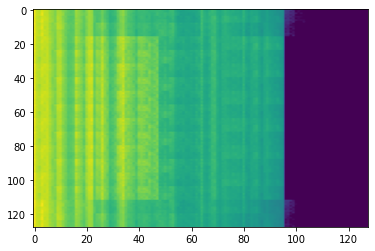

2020-11-07 01:39:39,937 - pytorch_modeler.py - INFO - Epoch 1/100:train_loss:932.267177, valid_AUC:0.519063, valid_pAUC:0.502729
100%|██████████| 1803/1803 [00:18<00:00, 97.80it/s]
2020-11-07 01:40:53,281 - pytorch_modeler.py - INFO - Epoch 2/100:train_loss:860.168040, valid_AUC:0.520763, valid_pAUC:0.502757
100%|██████████| 1803/1803 [00:19<00:00, 93.96it/s]
2020-11-07 01:42:08,055 - pytorch_modeler.py - INFO - Epoch 3/100:train_loss:794.190934, valid_AUC:0.521292, valid_pAUC:0.503207
100%|██████████| 1803/1803 [00:18<00:00, 97.36it/s]
2020-11-07 01:43:21,426 - pytorch_modeler.py - INFO - Epoch 4/100:train_loss:733.795489, valid_AUC:0.516565, valid_pAUC:0.505271
100%|██████████| 1803/1803 [00:18<00:00, 95.46it/s]
2020-11-07 01:44:35,546 - pytorch_modeler.py - INFO - Epoch 5/100:train_loss:678.309235, valid_AUC:0.519551, valid_pAUC:0.505477
100%|██████████| 1803/1803 [00:18<00:00, 95.86it/s]
2020-11-07 01:45:49,859 - pytorch_modeler.py - INFO - Epoch 6/100:train_loss:627.182864, valid_

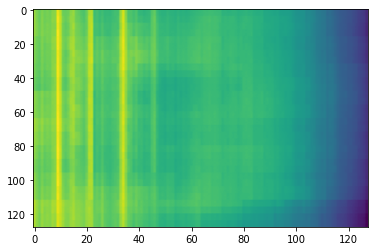

2020-11-07 01:50:44,615 - pytorch_modeler.py - INFO - Epoch 10/100:train_loss:456.323382, valid_AUC:0.525194, valid_pAUC:0.510138
100%|██████████| 1803/1803 [00:18<00:00, 98.40it/s]
2020-11-07 01:51:57,358 - pytorch_modeler.py - INFO - Epoch 11/100:train_loss:420.295431, valid_AUC:0.493300, valid_pAUC:0.521598
100%|██████████| 1803/1803 [00:18<00:00, 97.95it/s]
2020-11-07 01:53:10,280 - pytorch_modeler.py - INFO - Epoch 12/100:train_loss:386.556417, valid_AUC:0.455741, valid_pAUC:0.503461
100%|██████████| 1803/1803 [00:19<00:00, 94.88it/s]
2020-11-07 01:54:24,954 - pytorch_modeler.py - INFO - Epoch 13/100:train_loss:354.889654, valid_AUC:0.496028, valid_pAUC:0.508234
100%|██████████| 1803/1803 [00:18<00:00, 96.21it/s]
2020-11-07 01:55:39,901 - pytorch_modeler.py - INFO - Epoch 14/100:train_loss:325.216537, valid_AUC:0.486303, valid_pAUC:0.511329
100%|██████████| 1803/1803 [00:18<00:00, 96.42it/s]
2020-11-07 01:56:54,221 - pytorch_modeler.py - INFO - Epoch 15/100:train_loss:297.505322, 

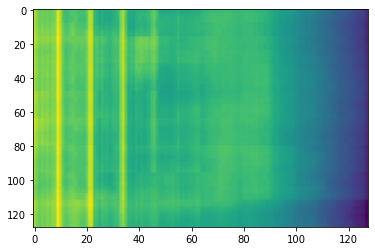

2020-11-07 02:03:07,121 - pytorch_modeler.py - INFO - Epoch 20/100:train_loss:183.992891, valid_AUC:0.471919, valid_pAUC:0.507034
100%|██████████| 1803/1803 [00:18<00:00, 94.93it/s]
2020-11-07 02:04:21,966 - pytorch_modeler.py - INFO - Epoch 21/100:train_loss:165.851875, valid_AUC:0.493978, valid_pAUC:0.506227
100%|██████████| 1803/1803 [00:19<00:00, 94.49it/s] 
2020-11-07 02:05:36,523 - pytorch_modeler.py - INFO - Epoch 22/100:train_loss:149.145562, valid_AUC:0.506531, valid_pAUC:0.513655
100%|██████████| 1803/1803 [00:18<00:00, 97.02it/s] 
2020-11-07 02:06:51,125 - pytorch_modeler.py - INFO - Epoch 23/100:train_loss:133.759806, valid_AUC:0.530832, valid_pAUC:0.511873
100%|██████████| 1803/1803 [00:18<00:00, 95.86it/s] 
2020-11-07 02:08:05,269 - pytorch_modeler.py - INFO - Epoch 24/100:train_loss:119.639403, valid_AUC:0.523345, valid_pAUC:0.500431
100%|██████████| 1803/1803 [00:20<00:00, 88.37it/s] 
2020-11-07 02:09:22,189 - pytorch_modeler.py - INFO - Epoch 25/100:train_loss:106.6908

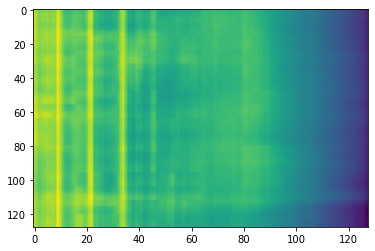

2020-11-07 02:15:36,559 - pytorch_modeler.py - INFO - Epoch 30/100:train_loss:57.734951, valid_AUC:0.475887, valid_pAUC:0.501848
100%|██████████| 1803/1803 [00:19<00:00, 94.26it/s]
2020-11-07 02:16:51,373 - pytorch_modeler.py - INFO - Epoch 31/100:train_loss:50.721061, valid_AUC:0.531281, valid_pAUC:0.508717
100%|██████████| 1803/1803 [00:19<00:00, 94.74it/s]
2020-11-07 02:18:06,044 - pytorch_modeler.py - INFO - Epoch 32/100:train_loss:44.489612, valid_AUC:0.574406, valid_pAUC:0.513439
100%|██████████| 1803/1803 [00:19<00:00, 92.31it/s]
2020-11-07 02:19:21,740 - pytorch_modeler.py - INFO - Epoch 33/100:train_loss:38.987831, valid_AUC:0.544368, valid_pAUC:0.505618
100%|██████████| 1803/1803 [00:18<00:00, 96.68it/s] 
2020-11-07 02:20:36,567 - pytorch_modeler.py - INFO - Epoch 34/100:train_loss:34.152284, valid_AUC:0.497252, valid_pAUC:0.509744
100%|██████████| 1803/1803 [00:19<00:00, 91.22it/s]
2020-11-07 02:21:51,797 - pytorch_modeler.py - INFO - Epoch 35/100:train_loss:29.905327, valid

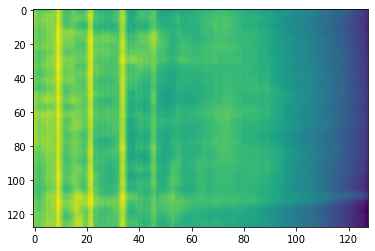

2020-11-07 02:28:06,380 - pytorch_modeler.py - INFO - Epoch 40/100:train_loss:16.282999, valid_AUC:0.619772, valid_pAUC:0.516468
100%|██████████| 1803/1803 [00:18<00:00, 97.88it/s] 
2020-11-07 02:29:21,069 - pytorch_modeler.py - INFO - Epoch 41/100:train_loss:14.733802, valid_AUC:0.599168, valid_pAUC:0.517219
100%|██████████| 1803/1803 [00:17<00:00, 100.72it/s]
2020-11-07 02:30:33,114 - pytorch_modeler.py - INFO - Epoch 42/100:train_loss:13.402905, valid_AUC:0.597707, valid_pAUC:0.519357
100%|██████████| 1803/1803 [00:18<00:00, 95.14it/s]
2020-11-07 02:31:46,567 - pytorch_modeler.py - INFO - Epoch 43/100:train_loss:12.348942, valid_AUC:0.585087, valid_pAUC:0.511423
100%|██████████| 1803/1803 [00:18<00:00, 96.88it/s] 
2020-11-07 02:33:00,408 - pytorch_modeler.py - INFO - Epoch 44/100:train_loss:11.512660, valid_AUC:0.617760, valid_pAUC:0.515155
100%|██████████| 1803/1803 [00:18<00:00, 95.76it/s]
2020-11-07 02:34:14,349 - pytorch_modeler.py - INFO - Epoch 45/100:train_loss:10.830709, val

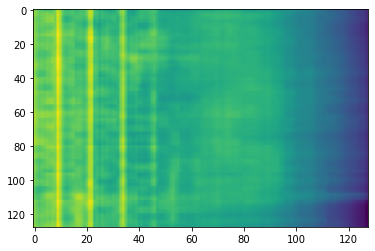

2020-11-07 02:40:26,447 - pytorch_modeler.py - INFO - Epoch 50/100:train_loss:9.122655, valid_AUC:0.648639, valid_pAUC:0.523118
100%|██████████| 1803/1803 [00:19<00:00, 93.71it/s] 
2020-11-07 02:41:40,896 - pytorch_modeler.py - INFO - Epoch 51/100:train_loss:8.994227, valid_AUC:0.648086, valid_pAUC:0.523061
100%|██████████| 1803/1803 [00:19<00:00, 93.68it/s]
2020-11-07 02:42:55,795 - pytorch_modeler.py - INFO - Epoch 52/100:train_loss:8.854463, valid_AUC:0.642899, valid_pAUC:0.523437
100%|██████████| 1803/1803 [00:19<00:00, 94.10it/s]
2020-11-07 02:44:10,442 - pytorch_modeler.py - INFO - Epoch 53/100:train_loss:8.755570, valid_AUC:0.638774, valid_pAUC:0.523333
100%|██████████| 1803/1803 [00:19<00:00, 93.18it/s] 
2020-11-07 02:45:25,049 - pytorch_modeler.py - INFO - Epoch 54/100:train_loss:8.685359, valid_AUC:0.665492, valid_pAUC:0.524281
100%|██████████| 1803/1803 [00:18<00:00, 97.07it/s] 
2020-11-07 02:46:39,290 - pytorch_modeler.py - INFO - Epoch 55/100:train_loss:8.622798, valid_AUC

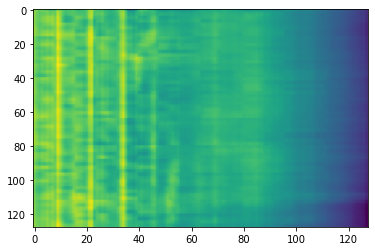

2020-11-07 02:53:58,037 - pytorch_modeler.py - INFO - Epoch 60/100:train_loss:8.338674, valid_AUC:0.642830, valid_pAUC:0.523746
100%|██████████| 1803/1803 [00:24<00:00, 74.31it/s]
2020-11-07 02:55:31,659 - pytorch_modeler.py - INFO - Epoch 61/100:train_loss:8.271038, valid_AUC:0.647874, valid_pAUC:0.522302
100%|██████████| 1803/1803 [00:21<00:00, 82.85it/s]
2020-11-07 02:57:03,299 - pytorch_modeler.py - INFO - Epoch 62/100:train_loss:8.210057, valid_AUC:0.655066, valid_pAUC:0.525819
100%|██████████| 1803/1803 [00:23<00:00, 75.62it/s]
2020-11-07 02:58:36,793 - pytorch_modeler.py - INFO - Epoch 63/100:train_loss:8.221708, valid_AUC:0.643592, valid_pAUC:0.521036
100%|██████████| 1803/1803 [00:25<00:00, 71.16it/s]
2020-11-07 03:00:12,125 - pytorch_modeler.py - INFO - Epoch 64/100:train_loss:8.166371, valid_AUC:0.645802, valid_pAUC:0.521917
100%|██████████| 1803/1803 [00:24<00:00, 72.50it/s]
2020-11-07 03:01:46,649 - pytorch_modeler.py - INFO - Epoch 65/100:train_loss:8.163148, valid_AUC:0.

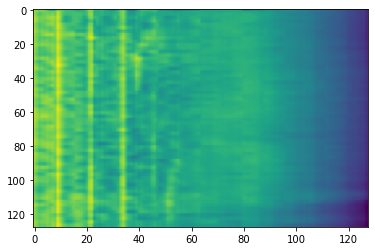

2020-11-07 03:08:10,833 - pytorch_modeler.py - INFO - Epoch 70/100:train_loss:7.953753, valid_AUC:0.643532, valid_pAUC:0.526100
100%|██████████| 1803/1803 [00:19<00:00, 93.23it/s]
2020-11-07 03:09:26,314 - pytorch_modeler.py - INFO - Epoch 71/100:train_loss:7.922500, valid_AUC:0.638667, valid_pAUC:0.526053
100%|██████████| 1803/1803 [00:18<00:00, 97.37it/s]
2020-11-07 03:10:40,606 - pytorch_modeler.py - INFO - Epoch 72/100:train_loss:7.913293, valid_AUC:0.635096, valid_pAUC:0.522171
100%|██████████| 1803/1803 [00:20<00:00, 89.57it/s]
2020-11-07 03:11:55,847 - pytorch_modeler.py - INFO - Epoch 73/100:train_loss:7.896983, valid_AUC:0.652876, valid_pAUC:0.526757
100%|██████████| 1803/1803 [00:18<00:00, 95.27it/s]
2020-11-07 03:13:10,484 - pytorch_modeler.py - INFO - Epoch 74/100:train_loss:7.848284, valid_AUC:0.656311, valid_pAUC:0.521692
100%|██████████| 1803/1803 [00:36<00:00, 49.74it/s]
2020-11-07 03:15:24,361 - pytorch_modeler.py - INFO - Epoch 75/100:train_loss:7.805396, valid_AUC:0.

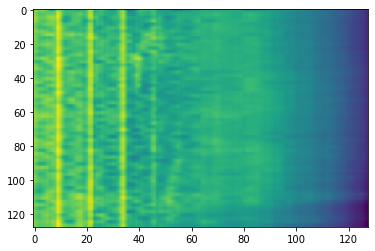

2020-11-07 03:27:09,233 - pytorch_modeler.py - INFO - Epoch 80/100:train_loss:7.696334, valid_AUC:0.657113, valid_pAUC:0.526635
100%|██████████| 1803/1803 [00:34<00:00, 52.32it/s]
2020-11-07 03:29:29,439 - pytorch_modeler.py - INFO - Epoch 81/100:train_loss:7.672163, valid_AUC:0.654738, valid_pAUC:0.527132
100%|██████████| 1803/1803 [00:36<00:00, 50.03it/s]
2020-11-07 03:31:50,356 - pytorch_modeler.py - INFO - Epoch 82/100:train_loss:7.664220, valid_AUC:0.647491, valid_pAUC:0.524712
100%|██████████| 1803/1803 [00:36<00:00, 50.07it/s]
2020-11-07 03:34:10,336 - pytorch_modeler.py - INFO - Epoch 83/100:train_loss:7.663031, valid_AUC:0.649626, valid_pAUC:0.523746
100%|██████████| 1803/1803 [00:33<00:00, 53.10it/s]
2020-11-07 03:36:29,039 - pytorch_modeler.py - INFO - Epoch 84/100:train_loss:7.626157, valid_AUC:0.661041, valid_pAUC:0.525537
100%|██████████| 1803/1803 [00:18<00:00, 95.79it/s] 
2020-11-07 03:37:42,613 - pytorch_modeler.py - INFO - Epoch 85/100:train_loss:7.615112, valid_AUC:0

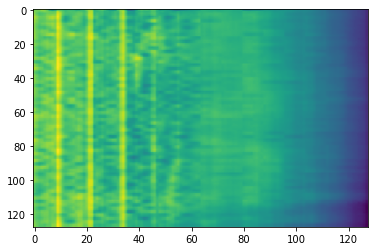

2020-11-07 03:44:14,105 - pytorch_modeler.py - INFO - Epoch 90/100:train_loss:7.530822, valid_AUC:0.656415, valid_pAUC:0.525819
100%|██████████| 1803/1803 [00:19<00:00, 94.19it/s]
2020-11-07 03:45:28,570 - pytorch_modeler.py - INFO - Epoch 91/100:train_loss:7.514520, valid_AUC:0.667055, valid_pAUC:0.528135
100%|██████████| 1803/1803 [00:18<00:00, 97.23it/s]
2020-11-07 03:46:42,193 - pytorch_modeler.py - INFO - Epoch 92/100:train_loss:7.516263, valid_AUC:0.665563, valid_pAUC:0.524337
100%|██████████| 1803/1803 [00:18<00:00, 96.96it/s]
2020-11-07 03:47:55,477 - pytorch_modeler.py - INFO - Epoch 93/100:train_loss:7.470356, valid_AUC:0.658813, valid_pAUC:0.525425
100%|██████████| 1803/1803 [00:18<00:00, 96.89it/s]
2020-11-07 03:49:09,258 - pytorch_modeler.py - INFO - Epoch 94/100:train_loss:7.468829, valid_AUC:0.666999, valid_pAUC:0.527160
100%|██████████| 1803/1803 [00:18<00:00, 97.18it/s]
2020-11-07 03:50:22,480 - pytorch_modeler.py - INFO - Epoch 95/100:train_loss:7.494485, valid_AUC:0.

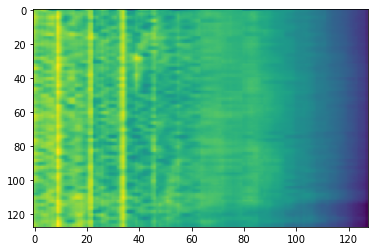

2020-11-07 03:56:29,910 - pytorch_modeler.py - INFO - Epoch 100/100:train_loss:7.384816, valid_AUC:0.655383, valid_pAUC:0.527507
2020-11-07 03:56:30,057 - 00_train.py - INFO - 
 success:fan 
model_out_path ==> 
 /media/hiroki/working/research/dcase2020/result/2D/LSTM3CNN_AE/models/fan_model.pth


elapsed time: 8361.142315388 [sec]


2020-11-07 03:56:30,667 - 00_train.py - INFO - TARGET MACHINE_TYPE: pump
2020-11-07 03:56:30,668 - 00_train.py - INFO - MAKE DATA_LOADER
2020-11-07 03:56:30,670 - 00_train.py - INFO - TRAINING
  0%|          | 0/91 [00:00<?, ?it/s]

use: cuda:0


100%|██████████| 832/832 [00:13<00:00, 63.71it/s]


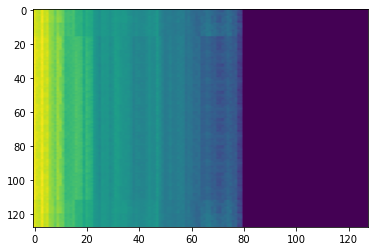

2020-11-07 03:58:26,764 - pytorch_modeler.py - INFO - Epoch 1/100:train_loss:936.252623, valid_AUC:0.304398, valid_pAUC:0.487086
100%|██████████| 832/832 [00:08<00:00, 99.18it/s] 
2020-11-07 03:59:23,296 - pytorch_modeler.py - INFO - Epoch 2/100:train_loss:872.241814, valid_AUC:0.300880, valid_pAUC:0.487543
100%|██████████| 832/832 [00:08<00:00, 100.54it/s]
2020-11-07 04:00:19,540 - pytorch_modeler.py - INFO - Epoch 3/100:train_loss:813.654058, valid_AUC:0.287969, valid_pAUC:0.487390
100%|██████████| 832/832 [00:08<00:00, 99.83it/s] 
2020-11-07 04:01:15,894 - pytorch_modeler.py - INFO - Epoch 4/100:train_loss:758.879596, valid_AUC:0.282807, valid_pAUC:0.488761
100%|██████████| 832/832 [00:08<00:00, 100.24it/s]
2020-11-07 04:02:12,261 - pytorch_modeler.py - INFO - Epoch 5/100:train_loss:707.640616, valid_AUC:0.294167, valid_pAUC:0.487908
100%|██████████| 832/832 [00:08<00:00, 100.03it/s]
2020-11-07 04:03:08,608 - pytorch_modeler.py - INFO - Epoch 6/100:train_loss:660.279554, valid_AUC:0

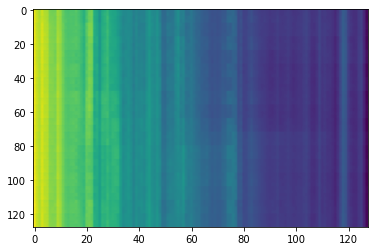

2020-11-07 04:06:54,088 - pytorch_modeler.py - INFO - Epoch 10/100:train_loss:499.827526, valid_AUC:0.281134, valid_pAUC:0.489736
100%|██████████| 832/832 [00:08<00:00, 100.46it/s]
2020-11-07 04:07:50,402 - pytorch_modeler.py - INFO - Epoch 11/100:train_loss:465.875953, valid_AUC:0.344855, valid_pAUC:0.490010
100%|██████████| 832/832 [00:08<00:00, 100.21it/s]
2020-11-07 04:08:46,768 - pytorch_modeler.py - INFO - Epoch 12/100:train_loss:433.387897, valid_AUC:0.385475, valid_pAUC:0.491929
100%|██████████| 832/832 [00:08<00:00, 99.18it/s] 
2020-11-07 04:09:43,147 - pytorch_modeler.py - INFO - Epoch 13/100:train_loss:402.866079, valid_AUC:0.337653, valid_pAUC:0.484497
100%|██████████| 832/832 [00:08<00:00, 100.51it/s]
2020-11-07 04:10:39,513 - pytorch_modeler.py - INFO - Epoch 14/100:train_loss:373.354212, valid_AUC:0.282263, valid_pAUC:0.486507
100%|██████████| 832/832 [00:08<00:00, 100.57it/s]
2020-11-07 04:11:35,788 - pytorch_modeler.py - INFO - Epoch 15/100:train_loss:345.460631, valid

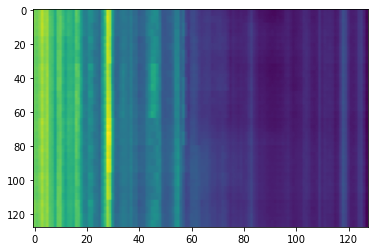

2020-11-07 04:16:17,716 - pytorch_modeler.py - INFO - Epoch 20/100:train_loss:230.411514, valid_AUC:0.351667, valid_pAUC:0.482487
100%|██████████| 832/832 [00:08<00:00, 100.27it/s]
2020-11-07 04:17:13,994 - pytorch_modeler.py - INFO - Epoch 21/100:train_loss:211.098692, valid_AUC:0.315880, valid_pAUC:0.490345
100%|██████████| 832/832 [00:08<00:00, 100.03it/s]
2020-11-07 04:18:10,409 - pytorch_modeler.py - INFO - Epoch 22/100:train_loss:193.171004, valid_AUC:0.335709, valid_pAUC:0.484405
100%|██████████| 832/832 [00:08<00:00, 99.75it/s] 
2020-11-07 04:19:06,759 - pytorch_modeler.py - INFO - Epoch 23/100:train_loss:176.127253, valid_AUC:0.445255, valid_pAUC:0.498173
100%|██████████| 832/832 [00:08<00:00, 100.46it/s]
2020-11-07 04:20:03,054 - pytorch_modeler.py - INFO - Epoch 24/100:train_loss:161.263811, valid_AUC:0.435006, valid_pAUC:0.497137
100%|██████████| 832/832 [00:08<00:00, 100.15it/s]
2020-11-07 04:20:59,318 - pytorch_modeler.py - INFO - Epoch 25/100:train_loss:146.062349, valid

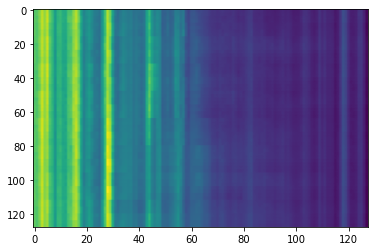

2020-11-07 04:25:40,984 - pytorch_modeler.py - INFO - Epoch 30/100:train_loss:88.188124, valid_AUC:0.565046, valid_pAUC:0.508985
100%|██████████| 832/832 [00:08<00:00, 99.55it/s] 
2020-11-07 04:26:37,325 - pytorch_modeler.py - INFO - Epoch 31/100:train_loss:79.370311, valid_AUC:0.504172, valid_pAUC:0.493969
100%|██████████| 832/832 [00:08<00:00, 99.56it/s] 
2020-11-07 04:27:33,726 - pytorch_modeler.py - INFO - Epoch 32/100:train_loss:70.961385, valid_AUC:0.610943, valid_pAUC:0.537007
100%|██████████| 832/832 [00:08<00:00, 99.62it/s] 
2020-11-07 04:28:30,095 - pytorch_modeler.py - INFO - Epoch 33/100:train_loss:63.568172, valid_AUC:0.495926, valid_pAUC:0.519615
100%|██████████| 832/832 [00:08<00:00, 99.50it/s]
2020-11-07 04:29:26,430 - pytorch_modeler.py - INFO - Epoch 34/100:train_loss:56.588339, valid_AUC:0.644456, valid_pAUC:0.568226
100%|██████████| 832/832 [00:08<00:00, 96.58it/s]
2020-11-07 04:30:23,014 - pytorch_modeler.py - INFO - Epoch 35/100:train_loss:50.694905, valid_AUC:0.5

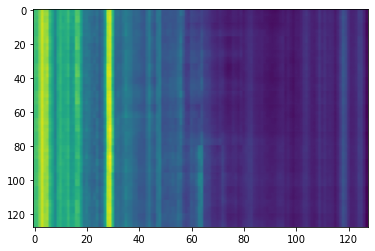

2020-11-07 04:35:11,113 - pytorch_modeler.py - INFO - Epoch 40/100:train_loss:28.841776, valid_AUC:0.508362, valid_pAUC:0.503746
100%|██████████| 832/832 [00:08<00:00, 97.78it/s]
2020-11-07 04:36:07,866 - pytorch_modeler.py - INFO - Epoch 41/100:train_loss:25.735484, valid_AUC:0.571325, valid_pAUC:0.536184
100%|██████████| 832/832 [00:08<00:00, 97.63it/s]
2020-11-07 04:37:04,673 - pytorch_modeler.py - INFO - Epoch 42/100:train_loss:22.983854, valid_AUC:0.680839, valid_pAUC:0.547332
100%|██████████| 832/832 [00:08<00:00, 97.14it/s]
2020-11-07 04:38:01,520 - pytorch_modeler.py - INFO - Epoch 43/100:train_loss:20.792530, valid_AUC:0.656545, valid_pAUC:0.551596
100%|██████████| 832/832 [00:08<00:00, 99.67it/s] 
2020-11-07 04:38:58,084 - pytorch_modeler.py - INFO - Epoch 44/100:train_loss:18.855073, valid_AUC:0.732836, valid_pAUC:0.600725
100%|██████████| 832/832 [00:08<00:00, 99.38it/s] 
2020-11-07 04:39:54,454 - pytorch_modeler.py - INFO - Epoch 45/100:train_loss:17.176549, valid_AUC:0.68

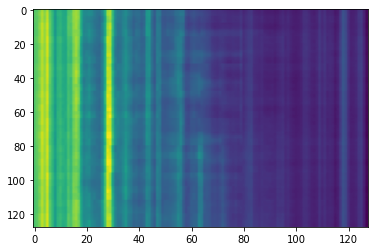

2020-11-07 04:44:36,541 - pytorch_modeler.py - INFO - Epoch 50/100:train_loss:12.212261, valid_AUC:0.712477, valid_pAUC:0.570510
100%|██████████| 832/832 [00:08<00:00, 99.72it/s] 
2020-11-07 04:45:32,881 - pytorch_modeler.py - INFO - Epoch 51/100:train_loss:11.660902, valid_AUC:0.680966, valid_pAUC:0.573069
100%|██████████| 832/832 [00:08<00:00, 100.02it/s]
2020-11-07 04:46:29,276 - pytorch_modeler.py - INFO - Epoch 52/100:train_loss:11.297578, valid_AUC:0.726250, valid_pAUC:0.586714
100%|██████████| 832/832 [00:08<00:00, 99.85it/s] 
2020-11-07 04:47:25,577 - pytorch_modeler.py - INFO - Epoch 53/100:train_loss:10.936118, valid_AUC:0.711522, valid_pAUC:0.622046
100%|██████████| 832/832 [00:08<00:00, 99.53it/s] 
2020-11-07 04:48:21,960 - pytorch_modeler.py - INFO - Epoch 54/100:train_loss:10.610695, valid_AUC:0.720903, valid_pAUC:0.553880
100%|██████████| 832/832 [00:08<00:00, 99.51it/s] 
2020-11-07 04:49:18,324 - pytorch_modeler.py - INFO - Epoch 55/100:train_loss:10.476688, valid_AUC:0

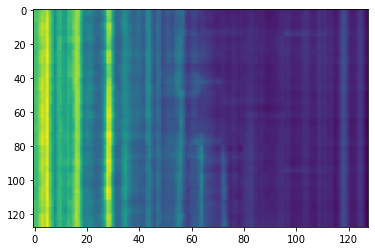

2020-11-07 04:54:00,279 - pytorch_modeler.py - INFO - Epoch 60/100:train_loss:9.926603, valid_AUC:0.720399, valid_pAUC:0.572094
100%|██████████| 832/832 [00:08<00:00, 99.75it/s] 
2020-11-07 04:54:56,647 - pytorch_modeler.py - INFO - Epoch 61/100:train_loss:9.884116, valid_AUC:0.735365, valid_pAUC:0.588694
100%|██████████| 832/832 [00:08<00:00, 99.75it/s] 
2020-11-07 04:55:53,005 - pytorch_modeler.py - INFO - Epoch 62/100:train_loss:9.874071, valid_AUC:0.704925, valid_pAUC:0.588268
100%|██████████| 832/832 [00:08<00:00, 100.11it/s]
2020-11-07 04:56:49,305 - pytorch_modeler.py - INFO - Epoch 63/100:train_loss:9.878183, valid_AUC:0.583495, valid_pAUC:0.492507
100%|██████████| 832/832 [00:08<00:00, 96.76it/s] 
2020-11-07 04:57:45,976 - pytorch_modeler.py - INFO - Epoch 64/100:train_loss:9.986463, valid_AUC:0.725909, valid_pAUC:0.590461
100%|██████████| 832/832 [00:08<00:00, 100.15it/s]
2020-11-07 04:58:42,212 - pytorch_modeler.py - INFO - Epoch 65/100:train_loss:9.843769, valid_AUC:0.72507

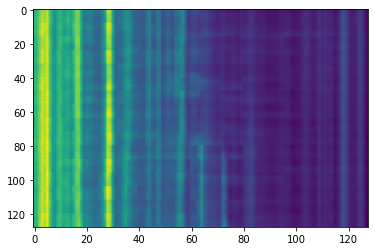

2020-11-07 05:03:23,984 - pytorch_modeler.py - INFO - Epoch 70/100:train_loss:9.596085, valid_AUC:0.730035, valid_pAUC:0.584278
100%|██████████| 832/832 [00:08<00:00, 99.92it/s] 
2020-11-07 05:04:20,280 - pytorch_modeler.py - INFO - Epoch 71/100:train_loss:9.601015, valid_AUC:0.717587, valid_pAUC:0.573465
100%|██████████| 832/832 [00:08<00:00, 99.80it/s] 
2020-11-07 05:05:16,596 - pytorch_modeler.py - INFO - Epoch 72/100:train_loss:9.596696, valid_AUC:0.739311, valid_pAUC:0.601151
100%|██████████| 832/832 [00:08<00:00, 99.82it/s] 
2020-11-07 05:06:12,944 - pytorch_modeler.py - INFO - Epoch 73/100:train_loss:9.585591, valid_AUC:0.722153, valid_pAUC:0.583333
100%|██████████| 832/832 [00:08<00:00, 99.89it/s] 
2020-11-07 05:07:09,294 - pytorch_modeler.py - INFO - Epoch 74/100:train_loss:9.531260, valid_AUC:0.721291, valid_pAUC:0.593750
100%|██████████| 832/832 [00:08<00:00, 99.70it/s] 
2020-11-07 05:08:05,675 - pytorch_modeler.py - INFO - Epoch 75/100:train_loss:9.569720, valid_AUC:0.71273

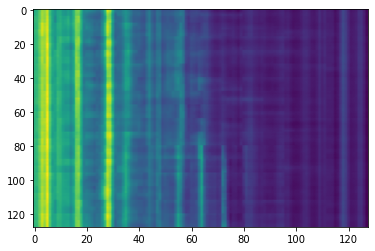

2020-11-07 05:12:47,524 - pytorch_modeler.py - INFO - Epoch 80/100:train_loss:9.520707, valid_AUC:0.730370, valid_pAUC:0.594329
100%|██████████| 832/832 [00:08<00:00, 98.45it/s] 
2020-11-07 05:13:43,982 - pytorch_modeler.py - INFO - Epoch 81/100:train_loss:9.400076, valid_AUC:0.726441, valid_pAUC:0.596034
100%|██████████| 832/832 [00:08<00:00, 99.84it/s] 
2020-11-07 05:14:40,317 - pytorch_modeler.py - INFO - Epoch 82/100:train_loss:9.373388, valid_AUC:0.735926, valid_pAUC:0.598410
100%|██████████| 832/832 [00:08<00:00, 100.02it/s]
2020-11-07 05:15:36,571 - pytorch_modeler.py - INFO - Epoch 83/100:train_loss:9.320038, valid_AUC:0.718478, valid_pAUC:0.579343
100%|██████████| 832/832 [00:08<00:00, 100.18it/s]
2020-11-07 05:16:32,944 - pytorch_modeler.py - INFO - Epoch 84/100:train_loss:9.318709, valid_AUC:0.746279, valid_pAUC:0.605050
100%|██████████| 832/832 [00:08<00:00, 100.06it/s]
2020-11-07 05:17:29,259 - pytorch_modeler.py - INFO - Epoch 85/100:train_loss:9.363047, valid_AUC:0.71901

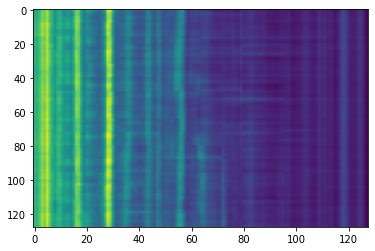

2020-11-07 05:22:11,084 - pytorch_modeler.py - INFO - Epoch 90/100:train_loss:9.158878, valid_AUC:0.721644, valid_pAUC:0.595182
100%|██████████| 832/832 [00:08<00:00, 100.24it/s]
2020-11-07 05:23:07,281 - pytorch_modeler.py - INFO - Epoch 91/100:train_loss:9.178982, valid_AUC:0.735990, valid_pAUC:0.595638
100%|██████████| 832/832 [00:08<00:00, 99.43it/s] 
2020-11-07 05:24:03,650 - pytorch_modeler.py - INFO - Epoch 92/100:train_loss:9.138374, valid_AUC:0.722529, valid_pAUC:0.587719
100%|██████████| 832/832 [00:08<00:00, 100.34it/s]
2020-11-07 05:24:59,858 - pytorch_modeler.py - INFO - Epoch 93/100:train_loss:9.104221, valid_AUC:0.679398, valid_pAUC:0.530367
100%|██████████| 832/832 [00:08<00:00, 99.77it/s] 
2020-11-07 05:25:56,232 - pytorch_modeler.py - INFO - Epoch 94/100:train_loss:9.158214, valid_AUC:0.741395, valid_pAUC:0.588146
100%|██████████| 832/832 [00:08<00:00, 99.81it/s] 
2020-11-07 05:26:52,556 - pytorch_modeler.py - INFO - Epoch 95/100:train_loss:9.048146, valid_AUC:0.74834

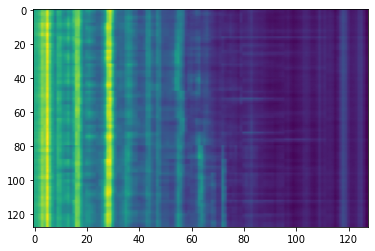

2020-11-07 05:31:34,405 - pytorch_modeler.py - INFO - Epoch 100/100:train_loss:8.910888, valid_AUC:0.727309, valid_pAUC:0.584217
2020-11-07 05:31:34,543 - 00_train.py - INFO - 
 success:pump 
model_out_path ==> 
 /media/hiroki/working/research/dcase2020/result/2D/LSTM3CNN_AE/models/pump_model.pth


elapsed time: 5703.877111435 [sec]


2020-11-07 05:31:35,164 - 00_train.py - INFO - TARGET MACHINE_TYPE: slider
2020-11-07 05:31:35,165 - 00_train.py - INFO - MAKE DATA_LOADER
2020-11-07 05:31:35,167 - 00_train.py - INFO - TRAINING
  0%|          | 0/81 [00:00<?, ?it/s]

use: cuda:0


100%|██████████| 1246/1246 [00:19<00:00, 63.61it/s]


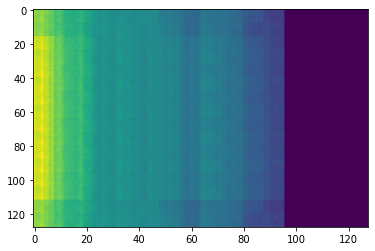

2020-11-07 05:33:26,778 - pytorch_modeler.py - INFO - Epoch 1/100:train_loss:1013.289362, valid_AUC:0.238132, valid_pAUC:0.479439
100%|██████████| 1246/1246 [00:12<00:00, 99.80it/s] 
2020-11-07 05:34:22,213 - pytorch_modeler.py - INFO - Epoch 2/100:train_loss:950.188611, valid_AUC:0.246803, valid_pAUC:0.479937
100%|██████████| 1246/1246 [00:12<00:00, 100.36it/s]
2020-11-07 05:35:17,584 - pytorch_modeler.py - INFO - Epoch 3/100:train_loss:893.679592, valid_AUC:0.248859, valid_pAUC:0.480403
100%|██████████| 1246/1246 [00:12<00:00, 100.15it/s]
2020-11-07 05:36:13,038 - pytorch_modeler.py - INFO - Epoch 4/100:train_loss:841.601566, valid_AUC:0.253322, valid_pAUC:0.480574
100%|██████████| 1246/1246 [00:12<00:00, 100.01it/s]
2020-11-07 05:37:08,488 - pytorch_modeler.py - INFO - Epoch 5/100:train_loss:792.786951, valid_AUC:0.259526, valid_pAUC:0.481103
100%|██████████| 1246/1246 [00:12<00:00, 100.30it/s]
2020-11-07 05:38:03,909 - pytorch_modeler.py - INFO - Epoch 6/100:train_loss:746.888337, 

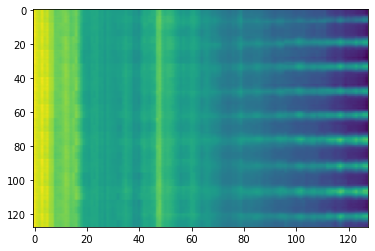

2020-11-07 05:41:45,997 - pytorch_modeler.py - INFO - Epoch 10/100:train_loss:587.845537, valid_AUC:0.379530, valid_pAUC:0.500373
100%|██████████| 1246/1246 [00:12<00:00, 100.05it/s]
2020-11-07 05:42:41,454 - pytorch_modeler.py - INFO - Epoch 11/100:train_loss:553.218662, valid_AUC:0.561897, valid_pAUC:0.529255
100%|██████████| 1246/1246 [00:12<00:00, 100.02it/s]
2020-11-07 05:43:36,919 - pytorch_modeler.py - INFO - Epoch 12/100:train_loss:520.365083, valid_AUC:0.401265, valid_pAUC:0.499565
100%|██████████| 1246/1246 [00:12<00:00, 100.41it/s]
2020-11-07 05:44:32,467 - pytorch_modeler.py - INFO - Epoch 13/100:train_loss:489.081271, valid_AUC:0.315749, valid_pAUC:0.495552
100%|██████████| 1246/1246 [00:12<00:00, 100.57it/s]
2020-11-07 05:45:27,873 - pytorch_modeler.py - INFO - Epoch 14/100:train_loss:459.372673, valid_AUC:0.544119, valid_pAUC:0.545166
100%|██████████| 1246/1246 [00:12<00:00, 100.02it/s]
2020-11-07 05:46:23,407 - pytorch_modeler.py - INFO - Epoch 15/100:train_loss:430.928

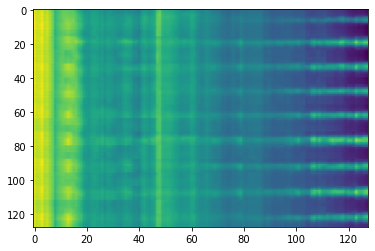

2020-11-07 05:51:00,996 - pytorch_modeler.py - INFO - Epoch 20/100:train_loss:308.235495, valid_AUC:0.445762, valid_pAUC:0.516502
100%|██████████| 1246/1246 [00:12<00:00, 100.27it/s]
2020-11-07 05:51:56,422 - pytorch_modeler.py - INFO - Epoch 21/100:train_loss:287.120325, valid_AUC:0.775844, valid_pAUC:0.637240
100%|██████████| 1246/1246 [00:12<00:00, 100.14it/s]
2020-11-07 05:52:51,892 - pytorch_modeler.py - INFO - Epoch 22/100:train_loss:267.107122, valid_AUC:0.646927, valid_pAUC:0.569631
100%|██████████| 1246/1246 [00:12<00:00, 98.91it/s] 
2020-11-07 05:53:47,566 - pytorch_modeler.py - INFO - Epoch 23/100:train_loss:248.118119, valid_AUC:0.682064, valid_pAUC:0.570860
100%|██████████| 1246/1246 [00:12<00:00, 100.04it/s]
2020-11-07 05:54:43,060 - pytorch_modeler.py - INFO - Epoch 24/100:train_loss:230.161165, valid_AUC:0.579530, valid_pAUC:0.573068
100%|██████████| 1246/1246 [00:12<00:00, 100.09it/s]
2020-11-07 05:55:38,474 - pytorch_modeler.py - INFO - Epoch 25/100:train_loss:213.165

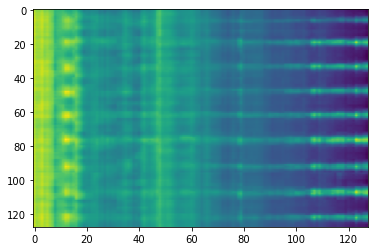

2020-11-07 06:00:15,899 - pytorch_modeler.py - INFO - Epoch 30/100:train_loss:141.919561, valid_AUC:0.653073, valid_pAUC:0.559568
100%|██████████| 1246/1246 [00:12<00:00, 100.04it/s]
2020-11-07 06:01:11,323 - pytorch_modeler.py - INFO - Epoch 31/100:train_loss:130.086783, valid_AUC:0.766563, valid_pAUC:0.629153
100%|██████████| 1246/1246 [00:12<00:00, 100.25it/s]
2020-11-07 06:02:06,810 - pytorch_modeler.py - INFO - Epoch 32/100:train_loss:119.058087, valid_AUC:0.743567, valid_pAUC:0.650445
100%|██████████| 1246/1246 [00:12<00:00, 100.07it/s]
2020-11-07 06:03:02,257 - pytorch_modeler.py - INFO - Epoch 33/100:train_loss:108.875516, valid_AUC:0.754858, valid_pAUC:0.598124
100%|██████████| 1246/1246 [00:12<00:00, 100.18it/s]
2020-11-07 06:03:57,715 - pytorch_modeler.py - INFO - Epoch 34/100:train_loss:99.279050, valid_AUC:0.698590, valid_pAUC:0.560144
100%|██████████| 1246/1246 [00:12<00:00, 100.21it/s]
2020-11-07 06:04:53,121 - pytorch_modeler.py - INFO - Epoch 35/100:train_loss:90.40323

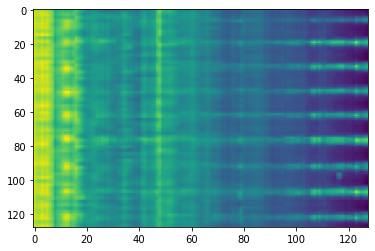

2020-11-07 06:09:30,604 - pytorch_modeler.py - INFO - Epoch 40/100:train_loss:55.070406, valid_AUC:0.775742, valid_pAUC:0.621407
100%|██████████| 1246/1246 [00:12<00:00, 100.30it/s]
2020-11-07 06:10:26,077 - pytorch_modeler.py - INFO - Epoch 41/100:train_loss:49.658512, valid_AUC:0.804261, valid_pAUC:0.649107
100%|██████████| 1246/1246 [00:12<00:00, 99.86it/s] 
2020-11-07 06:11:21,556 - pytorch_modeler.py - INFO - Epoch 42/100:train_loss:44.732892, valid_AUC:0.839598, valid_pAUC:0.708442
100%|██████████| 1246/1246 [00:13<00:00, 95.26it/s]
2020-11-07 06:12:17,707 - pytorch_modeler.py - INFO - Epoch 43/100:train_loss:40.227363, valid_AUC:0.800748, valid_pAUC:0.656231
100%|██████████| 1246/1246 [00:12<00:00, 100.37it/s]
2020-11-07 06:13:13,231 - pytorch_modeler.py - INFO - Epoch 44/100:train_loss:36.143193, valid_AUC:0.843933, valid_pAUC:0.643617
100%|██████████| 1246/1246 [00:12<00:00, 100.08it/s]
2020-11-07 06:14:08,736 - pytorch_modeler.py - INFO - Epoch 45/100:train_loss:32.475259, va

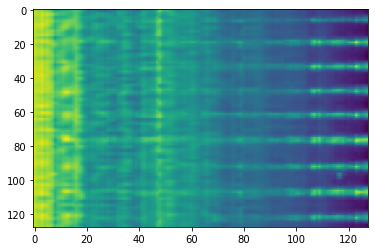

2020-11-07 06:18:46,258 - pytorch_modeler.py - INFO - Epoch 50/100:train_loss:19.366771, valid_AUC:0.848387, valid_pAUC:0.666931
100%|██████████| 1246/1246 [00:12<00:00, 99.04it/s] 
2020-11-07 06:19:41,824 - pytorch_modeler.py - INFO - Epoch 51/100:train_loss:17.515161, valid_AUC:0.787736, valid_pAUC:0.633912
100%|██████████| 1246/1246 [00:12<00:00, 100.33it/s]
2020-11-07 06:20:37,218 - pytorch_modeler.py - INFO - Epoch 52/100:train_loss:15.926263, valid_AUC:0.853357, valid_pAUC:0.682531
100%|██████████| 1246/1246 [00:12<00:00, 100.49it/s]
2020-11-07 06:21:32,516 - pytorch_modeler.py - INFO - Epoch 53/100:train_loss:14.518057, valid_AUC:0.846367, valid_pAUC:0.674350
100%|██████████| 1246/1246 [00:12<00:00, 99.90it/s]
2020-11-07 06:22:28,015 - pytorch_modeler.py - INFO - Epoch 54/100:train_loss:13.319316, valid_AUC:0.862976, valid_pAUC:0.697851
100%|██████████| 1246/1246 [00:12<00:00, 100.51it/s]
2020-11-07 06:23:23,396 - pytorch_modeler.py - INFO - Epoch 55/100:train_loss:12.250803, va

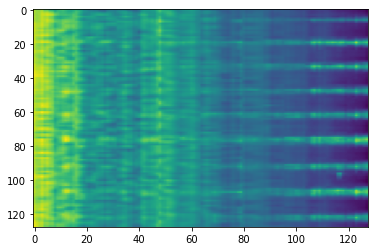

2020-11-07 06:28:00,684 - pytorch_modeler.py - INFO - Epoch 60/100:train_loss:9.009924, valid_AUC:0.883915, valid_pAUC:0.762800
100%|██████████| 1246/1246 [00:12<00:00, 100.21it/s]
2020-11-07 06:28:56,079 - pytorch_modeler.py - INFO - Epoch 61/100:train_loss:8.637157, valid_AUC:0.873910, valid_pAUC:0.729174
100%|██████████| 1246/1246 [00:12<00:00, 100.10it/s]
2020-11-07 06:29:51,575 - pytorch_modeler.py - INFO - Epoch 62/100:train_loss:8.352323, valid_AUC:0.850889, valid_pAUC:0.681691
100%|██████████| 1246/1246 [00:12<00:00, 100.23it/s]
2020-11-07 06:30:46,975 - pytorch_modeler.py - INFO - Epoch 63/100:train_loss:8.083075, valid_AUC:0.877940, valid_pAUC:0.744556
100%|██████████| 1246/1246 [00:12<00:00, 98.81it/s] 
2020-11-07 06:31:42,590 - pytorch_modeler.py - INFO - Epoch 64/100:train_loss:7.915980, valid_AUC:0.874900, valid_pAUC:0.722549
100%|██████████| 1246/1246 [00:12<00:00, 100.20it/s]
2020-11-07 06:32:38,037 - pytorch_modeler.py - INFO - Epoch 65/100:train_loss:7.726604, valid_A

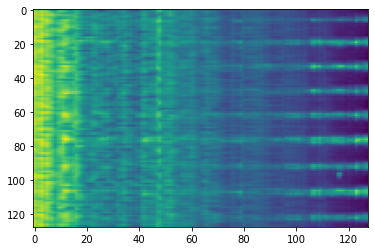

2020-11-07 06:37:15,408 - pytorch_modeler.py - INFO - Epoch 70/100:train_loss:7.055855, valid_AUC:0.879093, valid_pAUC:0.745521
100%|██████████| 1246/1246 [00:12<00:00, 100.13it/s]
2020-11-07 06:38:10,888 - pytorch_modeler.py - INFO - Epoch 71/100:train_loss:6.989780, valid_AUC:0.876238, valid_pAUC:0.743577
100%|██████████| 1246/1246 [00:12<00:00, 99.49it/s] 
2020-11-07 06:39:06,466 - pytorch_modeler.py - INFO - Epoch 72/100:train_loss:6.887334, valid_AUC:0.873191, valid_pAUC:0.736655
100%|██████████| 1246/1246 [00:12<00:00, 100.02it/s]
2020-11-07 06:40:01,933 - pytorch_modeler.py - INFO - Epoch 73/100:train_loss:6.797555, valid_AUC:0.866241, valid_pAUC:0.714632
100%|██████████| 1246/1246 [00:12<00:00, 100.32it/s]
2020-11-07 06:40:57,365 - pytorch_modeler.py - INFO - Epoch 74/100:train_loss:6.746174, valid_AUC:0.874521, valid_pAUC:0.732565
100%|██████████| 1246/1246 [00:12<00:00, 100.30it/s]
2020-11-07 06:41:52,778 - pytorch_modeler.py - INFO - Epoch 75/100:train_loss:6.694659, valid_A

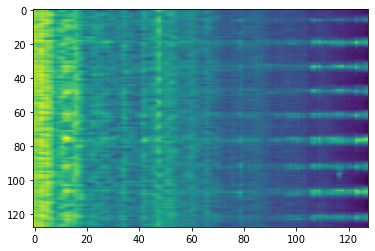

2020-11-07 06:46:30,256 - pytorch_modeler.py - INFO - Epoch 80/100:train_loss:6.496442, valid_AUC:0.885340, valid_pAUC:0.761789
100%|██████████| 1246/1246 [00:12<00:00, 100.19it/s]
2020-11-07 06:47:25,682 - pytorch_modeler.py - INFO - Epoch 81/100:train_loss:6.403685, valid_AUC:0.873723, valid_pAUC:0.731399
100%|██████████| 1246/1246 [00:12<00:00, 100.22it/s]
2020-11-07 06:48:21,117 - pytorch_modeler.py - INFO - Epoch 82/100:train_loss:6.353938, valid_AUC:0.867423, valid_pAUC:0.712828
100%|██████████| 1246/1246 [00:12<00:00, 99.84it/s] 
2020-11-07 06:49:16,563 - pytorch_modeler.py - INFO - Epoch 83/100:train_loss:6.298761, valid_AUC:0.879362, valid_pAUC:0.742472
100%|██████████| 1246/1246 [00:12<00:00, 100.34it/s]
2020-11-07 06:50:11,987 - pytorch_modeler.py - INFO - Epoch 84/100:train_loss:6.237202, valid_AUC:0.872796, valid_pAUC:0.725862
100%|██████████| 1246/1246 [00:12<00:00, 100.19it/s]
2020-11-07 06:51:07,399 - pytorch_modeler.py - INFO - Epoch 85/100:train_loss:6.130810, valid_A

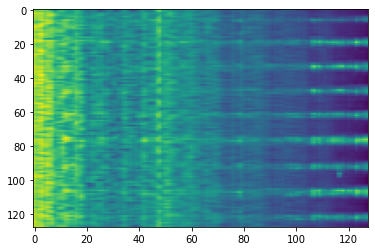

2020-11-07 06:55:44,863 - pytorch_modeler.py - INFO - Epoch 90/100:train_loss:5.973429, valid_AUC:0.867976, valid_pAUC:0.705643
100%|██████████| 1246/1246 [00:12<00:00, 99.98it/s] 
2020-11-07 06:56:40,333 - pytorch_modeler.py - INFO - Epoch 91/100:train_loss:5.926904, valid_AUC:0.872488, valid_pAUC:0.716670
100%|██████████| 1246/1246 [00:12<00:00, 100.00it/s]
2020-11-07 06:57:35,841 - pytorch_modeler.py - INFO - Epoch 92/100:train_loss:5.858460, valid_AUC:0.873691, valid_pAUC:0.725068
100%|██████████| 1246/1246 [00:12<00:00, 100.61it/s]
2020-11-07 06:58:31,235 - pytorch_modeler.py - INFO - Epoch 93/100:train_loss:5.861045, valid_AUC:0.873277, valid_pAUC:0.719687
100%|██████████| 1246/1246 [00:12<00:00, 100.26it/s]
2020-11-07 06:59:26,693 - pytorch_modeler.py - INFO - Epoch 94/100:train_loss:5.863540, valid_AUC:0.877459, valid_pAUC:0.731212
100%|██████████| 1246/1246 [00:12<00:00, 100.08it/s]
2020-11-07 07:00:22,093 - pytorch_modeler.py - INFO - Epoch 95/100:train_loss:5.793699, valid_A

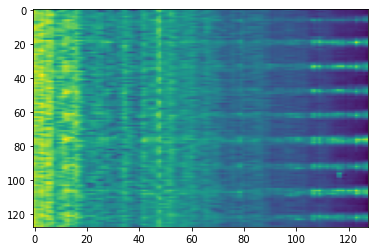

2020-11-07 07:04:59,450 - pytorch_modeler.py - INFO - Epoch 100/100:train_loss:5.548649, valid_AUC:0.864051, valid_pAUC:0.692407
2020-11-07 07:04:59,587 - 00_train.py - INFO - 
 success:slider 
model_out_path ==> 
 /media/hiroki/working/research/dcase2020/result/2D/LSTM3CNN_AE/models/slider_model.pth


elapsed time: 5604.423773527 [sec]


2020-11-07 07:05:00,204 - 00_train.py - INFO - TARGET MACHINE_TYPE: ToyCar
2020-11-07 07:05:00,205 - 00_train.py - INFO - MAKE DATA_LOADER
2020-11-07 07:05:00,207 - 00_train.py - INFO - TRAINING
  0%|          | 0/110 [00:00<?, ?it/s]

use: cuda:0


100%|██████████| 2407/2407 [00:39<00:00, 60.29it/s]


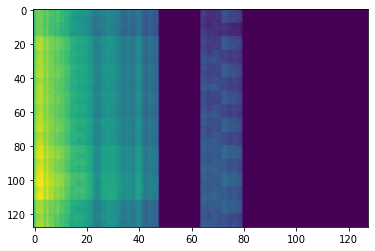

2020-11-07 07:07:48,385 - pytorch_modeler.py - INFO - Epoch 1/100:train_loss:870.156607, valid_AUC:0.438461, valid_pAUC:0.501023
100%|██████████| 2407/2407 [00:24<00:00, 98.01it/s]
2020-11-07 07:09:11,435 - pytorch_modeler.py - INFO - Epoch 2/100:train_loss:793.233602, valid_AUC:0.438895, valid_pAUC:0.498495
100%|██████████| 2407/2407 [00:24<00:00, 98.44it/s]
2020-11-07 07:10:34,339 - pytorch_modeler.py - INFO - Epoch 3/100:train_loss:716.107510, valid_AUC:0.427146, valid_pAUC:0.498376
100%|██████████| 2407/2407 [00:24<00:00, 97.90it/s]
2020-11-07 07:11:57,532 - pytorch_modeler.py - INFO - Epoch 4/100:train_loss:648.751282, valid_AUC:0.421042, valid_pAUC:0.497592
100%|██████████| 2407/2407 [00:24<00:00, 98.44it/s]
2020-11-07 07:13:20,537 - pytorch_modeler.py - INFO - Epoch 5/100:train_loss:588.712204, valid_AUC:0.417060, valid_pAUC:0.497293
100%|██████████| 2407/2407 [00:24<00:00, 97.85it/s]
2020-11-07 07:14:43,795 - pytorch_modeler.py - INFO - Epoch 6/100:train_loss:532.816272, valid_

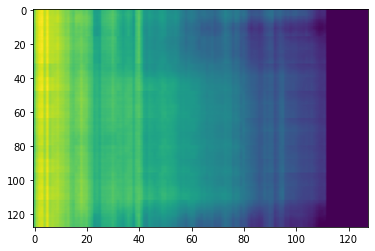

2020-11-07 07:20:16,302 - pytorch_modeler.py - INFO - Epoch 10/100:train_loss:358.852853, valid_AUC:0.389724, valid_pAUC:0.494964
100%|██████████| 2407/2407 [00:24<00:00, 97.78it/s]
2020-11-07 07:21:39,434 - pytorch_modeler.py - INFO - Epoch 11/100:train_loss:324.308344, valid_AUC:0.395194, valid_pAUC:0.494523
100%|██████████| 2407/2407 [00:24<00:00, 98.34it/s]
2020-11-07 07:23:02,674 - pytorch_modeler.py - INFO - Epoch 12/100:train_loss:292.962449, valid_AUC:0.385932, valid_pAUC:0.494702
100%|██████████| 2407/2407 [00:24<00:00, 98.21it/s]
2020-11-07 07:24:25,935 - pytorch_modeler.py - INFO - Epoch 13/100:train_loss:264.256572, valid_AUC:0.377847, valid_pAUC:0.491641
100%|██████████| 2407/2407 [00:24<00:00, 97.71it/s]
2020-11-07 07:25:49,135 - pytorch_modeler.py - INFO - Epoch 14/100:train_loss:236.719493, valid_AUC:0.416837, valid_pAUC:0.498410
100%|██████████| 2407/2407 [00:24<00:00, 98.50it/s]
2020-11-07 07:27:12,046 - pytorch_modeler.py - INFO - Epoch 15/100:train_loss:209.823752, 

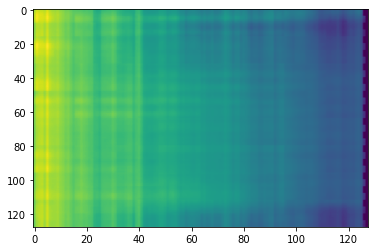

2020-11-07 07:34:07,793 - pytorch_modeler.py - INFO - Epoch 20/100:train_loss:116.970726, valid_AUC:0.466410, valid_pAUC:0.504416
100%|██████████| 2407/2407 [00:24<00:00, 98.57it/s]
2020-11-07 07:35:30,796 - pytorch_modeler.py - INFO - Epoch 21/100:train_loss:103.113731, valid_AUC:0.494939, valid_pAUC:0.518622
100%|██████████| 2407/2407 [00:24<00:00, 98.34it/s]
2020-11-07 07:36:53,927 - pytorch_modeler.py - INFO - Epoch 22/100:train_loss:90.177259, valid_AUC:0.676750, valid_pAUC:0.542933
100%|██████████| 2407/2407 [00:24<00:00, 98.19it/s]
2020-11-07 07:38:17,064 - pytorch_modeler.py - INFO - Epoch 23/100:train_loss:78.895006, valid_AUC:0.375512, valid_pAUC:0.492477
100%|██████████| 2407/2407 [00:24<00:00, 97.25it/s]
2020-11-07 07:39:40,433 - pytorch_modeler.py - INFO - Epoch 24/100:train_loss:69.048641, valid_AUC:0.668138, valid_pAUC:0.529803
100%|██████████| 2407/2407 [00:24<00:00, 98.15it/s]
2020-11-07 07:41:03,553 - pytorch_modeler.py - INFO - Epoch 25/100:train_loss:60.138528, vali

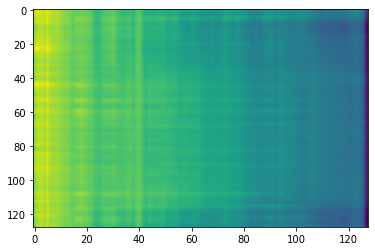

2020-11-07 07:47:59,202 - pytorch_modeler.py - INFO - Epoch 30/100:train_loss:29.926305, valid_AUC:0.747083, valid_pAUC:0.577913
100%|██████████| 2407/2407 [00:24<00:00, 98.18it/s]
2020-11-07 07:49:22,236 - pytorch_modeler.py - INFO - Epoch 31/100:train_loss:26.076025, valid_AUC:0.504515, valid_pAUC:0.538408
100%|██████████| 2407/2407 [00:24<00:00, 98.45it/s]
2020-11-07 07:50:45,350 - pytorch_modeler.py - INFO - Epoch 32/100:train_loss:22.845097, valid_AUC:0.632146, valid_pAUC:0.556488
100%|██████████| 2407/2407 [00:24<00:00, 98.53it/s]
2020-11-07 07:52:08,457 - pytorch_modeler.py - INFO - Epoch 33/100:train_loss:20.166806, valid_AUC:0.683113, valid_pAUC:0.536836
100%|██████████| 2407/2407 [00:24<00:00, 98.39it/s]
2020-11-07 07:53:31,516 - pytorch_modeler.py - INFO - Epoch 34/100:train_loss:17.924048, valid_AUC:0.724733, valid_pAUC:0.539621
100%|██████████| 2407/2407 [00:24<00:00, 98.22it/s]
2020-11-07 07:54:54,582 - pytorch_modeler.py - INFO - Epoch 35/100:train_loss:16.117628, valid_

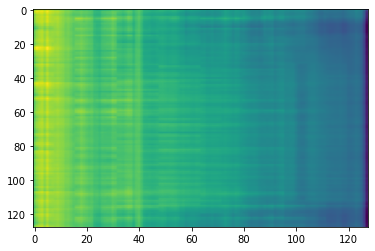

2020-11-07 08:01:50,477 - pytorch_modeler.py - INFO - Epoch 40/100:train_loss:11.191487, valid_AUC:0.743486, valid_pAUC:0.592891
100%|██████████| 2407/2407 [00:24<00:00, 98.22it/s]
2020-11-07 08:03:13,463 - pytorch_modeler.py - INFO - Epoch 41/100:train_loss:10.754769, valid_AUC:0.710663, valid_pAUC:0.564473
100%|██████████| 2407/2407 [00:24<00:00, 98.35it/s]
2020-11-07 08:04:36,584 - pytorch_modeler.py - INFO - Epoch 42/100:train_loss:10.400013, valid_AUC:0.704699, valid_pAUC:0.569181
100%|██████████| 2407/2407 [00:24<00:00, 97.77it/s]
2020-11-07 08:05:59,749 - pytorch_modeler.py - INFO - Epoch 43/100:train_loss:10.110425, valid_AUC:0.701297, valid_pAUC:0.567423
100%|██████████| 2407/2407 [00:24<00:00, 98.48it/s]
2020-11-07 08:07:22,732 - pytorch_modeler.py - INFO - Epoch 44/100:train_loss:9.943865, valid_AUC:0.709393, valid_pAUC:0.564227
100%|██████████| 2407/2407 [00:24<00:00, 98.45it/s]
2020-11-07 08:08:45,707 - pytorch_modeler.py - INFO - Epoch 45/100:train_loss:9.775537, valid_AU

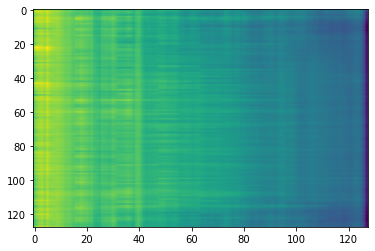

2020-11-07 08:15:41,191 - pytorch_modeler.py - INFO - Epoch 50/100:train_loss:9.388217, valid_AUC:0.724175, valid_pAUC:0.583506
100%|██████████| 2407/2407 [00:24<00:00, 98.48it/s]
2020-11-07 08:17:04,115 - pytorch_modeler.py - INFO - Epoch 51/100:train_loss:9.322920, valid_AUC:0.743010, valid_pAUC:0.571242
100%|██████████| 2407/2407 [00:24<00:00, 98.56it/s]
2020-11-07 08:18:27,047 - pytorch_modeler.py - INFO - Epoch 52/100:train_loss:9.265285, valid_AUC:0.741700, valid_pAUC:0.571468
100%|██████████| 2407/2407 [00:24<00:00, 97.74it/s]
2020-11-07 08:19:50,235 - pytorch_modeler.py - INFO - Epoch 53/100:train_loss:9.290733, valid_AUC:0.752763, valid_pAUC:0.571488
100%|██████████| 2407/2407 [00:24<00:00, 98.48it/s]
2020-11-07 08:21:13,252 - pytorch_modeler.py - INFO - Epoch 54/100:train_loss:9.229572, valid_AUC:0.738965, valid_pAUC:0.579593
100%|██████████| 2407/2407 [00:24<00:00, 98.46it/s]
2020-11-07 08:22:36,295 - pytorch_modeler.py - INFO - Epoch 55/100:train_loss:9.202543, valid_AUC:0.

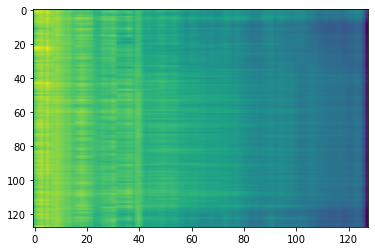

2020-11-07 08:29:31,654 - pytorch_modeler.py - INFO - Epoch 60/100:train_loss:9.030258, valid_AUC:0.733783, valid_pAUC:0.556070
100%|██████████| 2407/2407 [00:24<00:00, 98.56it/s]
2020-11-07 08:30:54,672 - pytorch_modeler.py - INFO - Epoch 61/100:train_loss:9.035742, valid_AUC:0.743169, valid_pAUC:0.580724
100%|██████████| 2407/2407 [00:24<00:00, 98.40it/s]
2020-11-07 08:32:17,661 - pytorch_modeler.py - INFO - Epoch 62/100:train_loss:8.974863, valid_AUC:0.753610, valid_pAUC:0.585708
100%|██████████| 2407/2407 [00:24<00:00, 97.55it/s]
2020-11-07 08:33:40,923 - pytorch_modeler.py - INFO - Epoch 63/100:train_loss:8.995963, valid_AUC:0.760077, valid_pAUC:0.583431
100%|██████████| 2407/2407 [00:24<00:00, 98.37it/s]
2020-11-07 08:35:03,943 - pytorch_modeler.py - INFO - Epoch 64/100:train_loss:8.933577, valid_AUC:0.624982, valid_pAUC:0.527981
100%|██████████| 2407/2407 [00:24<00:00, 98.30it/s]
2020-11-07 08:36:27,026 - pytorch_modeler.py - INFO - Epoch 65/100:train_loss:8.905254, valid_AUC:0.

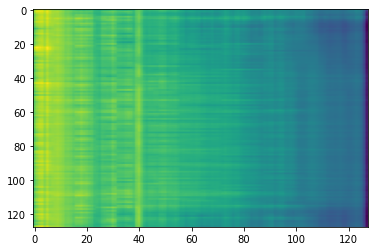

2020-11-07 08:43:22,309 - pytorch_modeler.py - INFO - Epoch 70/100:train_loss:8.801423, valid_AUC:0.748593, valid_pAUC:0.590203
100%|██████████| 2407/2407 [00:24<00:00, 98.46it/s]
2020-11-07 08:44:45,264 - pytorch_modeler.py - INFO - Epoch 71/100:train_loss:8.822125, valid_AUC:0.714199, valid_pAUC:0.558519
100%|██████████| 2407/2407 [00:24<00:00, 98.27it/s]
2020-11-07 08:46:08,351 - pytorch_modeler.py - INFO - Epoch 72/100:train_loss:8.784435, valid_AUC:0.693707, valid_pAUC:0.556230
100%|██████████| 2407/2407 [00:24<00:00, 98.38it/s]
2020-11-07 08:47:31,297 - pytorch_modeler.py - INFO - Epoch 73/100:train_loss:8.784751, valid_AUC:0.716978, valid_pAUC:0.576666
100%|██████████| 2407/2407 [00:24<00:00, 98.40it/s]
2020-11-07 08:48:54,287 - pytorch_modeler.py - INFO - Epoch 74/100:train_loss:8.725257, valid_AUC:0.749106, valid_pAUC:0.566217
100%|██████████| 2407/2407 [00:24<00:00, 98.40it/s]
2020-11-07 08:50:17,304 - pytorch_modeler.py - INFO - Epoch 75/100:train_loss:8.714237, valid_AUC:0.

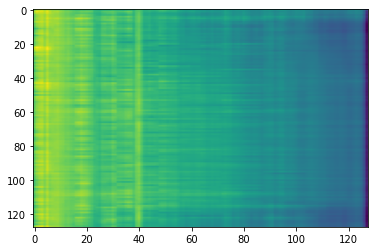

2020-11-07 08:57:12,672 - pytorch_modeler.py - INFO - Epoch 80/100:train_loss:8.685627, valid_AUC:0.699072, valid_pAUC:0.548715
100%|██████████| 2407/2407 [00:24<00:00, 98.52it/s]
2020-11-07 08:58:35,646 - pytorch_modeler.py - INFO - Epoch 81/100:train_loss:8.604214, valid_AUC:0.721523, valid_pAUC:0.571156
100%|██████████| 2407/2407 [00:24<00:00, 97.72it/s]
2020-11-07 08:59:58,790 - pytorch_modeler.py - INFO - Epoch 82/100:train_loss:8.530925, valid_AUC:0.726791, valid_pAUC:0.565190
100%|██████████| 2407/2407 [00:24<00:00, 98.39it/s]
2020-11-07 09:01:21,777 - pytorch_modeler.py - INFO - Epoch 83/100:train_loss:8.536394, valid_AUC:0.732233, valid_pAUC:0.561647
100%|██████████| 2407/2407 [00:24<00:00, 98.42it/s]
2020-11-07 09:02:44,823 - pytorch_modeler.py - INFO - Epoch 84/100:train_loss:8.523605, valid_AUC:0.556741, valid_pAUC:0.523923
100%|██████████| 2407/2407 [00:24<00:00, 98.24it/s]
2020-11-07 09:04:07,765 - pytorch_modeler.py - INFO - Epoch 85/100:train_loss:8.882026, valid_AUC:0.

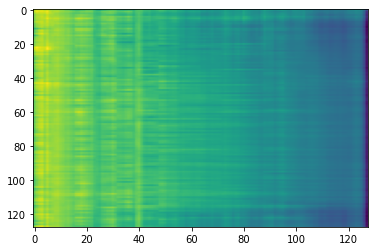

2020-11-07 09:11:02,931 - pytorch_modeler.py - INFO - Epoch 90/100:train_loss:8.419026, valid_AUC:0.716184, valid_pAUC:0.571093
100%|██████████| 2407/2407 [00:24<00:00, 98.65it/s]
2020-11-07 09:12:25,772 - pytorch_modeler.py - INFO - Epoch 91/100:train_loss:8.408197, valid_AUC:0.695456, valid_pAUC:0.548596
100%|██████████| 2407/2407 [00:24<00:00, 97.62it/s]
2020-11-07 09:13:49,019 - pytorch_modeler.py - INFO - Epoch 92/100:train_loss:8.393051, valid_AUC:0.734206, valid_pAUC:0.571690
100%|██████████| 2407/2407 [00:24<00:00, 98.37it/s]
2020-11-07 09:15:11,949 - pytorch_modeler.py - INFO - Epoch 93/100:train_loss:8.355493, valid_AUC:0.678646, valid_pAUC:0.547170
100%|██████████| 2407/2407 [00:24<00:00, 98.43it/s]
2020-11-07 09:16:35,002 - pytorch_modeler.py - INFO - Epoch 94/100:train_loss:8.336495, valid_AUC:0.692803, valid_pAUC:0.562633
100%|██████████| 2407/2407 [00:24<00:00, 97.59it/s]
2020-11-07 09:17:58,179 - pytorch_modeler.py - INFO - Epoch 95/100:train_loss:8.316906, valid_AUC:0.

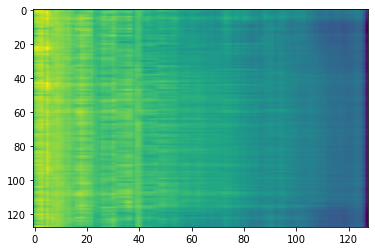

2020-11-07 09:24:53,308 - pytorch_modeler.py - INFO - Epoch 100/100:train_loss:8.239079, valid_AUC:0.697664, valid_pAUC:0.550720
2020-11-07 09:24:53,442 - 00_train.py - INFO - 
 success:ToyCar 
model_out_path ==> 
 /media/hiroki/working/research/dcase2020/result/2D/LSTM3CNN_AE/models/ToyCar_model.pth


elapsed time: 8393.238274097 [sec]


2020-11-07 09:24:54,176 - 00_train.py - INFO - TARGET MACHINE_TYPE: ToyConveyor
2020-11-07 09:24:54,177 - 00_train.py - INFO - MAKE DATA_LOADER
2020-11-07 09:24:54,179 - 00_train.py - INFO - TRAINING
  0%|          | 0/94 [00:00<?, ?it/s]

use: cuda:0


100%|██████████| 3452/3452 [00:55<00:00, 61.84it/s]


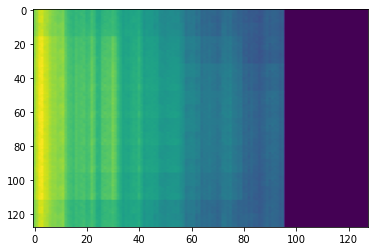

2020-11-07 09:27:38,667 - pytorch_modeler.py - INFO - Epoch 1/100:train_loss:521.828562, valid_AUC:0.467927, valid_pAUC:0.496683
100%|██████████| 3452/3452 [00:35<00:00, 97.88it/s]
2020-11-07 09:29:03,780 - pytorch_modeler.py - INFO - Epoch 2/100:train_loss:463.408199, valid_AUC:0.468791, valid_pAUC:0.497243
100%|██████████| 3452/3452 [00:35<00:00, 98.33it/s]
2020-11-07 09:30:28,808 - pytorch_modeler.py - INFO - Epoch 3/100:train_loss:412.817020, valid_AUC:0.469014, valid_pAUC:0.496997
100%|██████████| 3452/3452 [00:35<00:00, 97.76it/s]
2020-11-07 09:31:54,059 - pytorch_modeler.py - INFO - Epoch 4/100:train_loss:367.541357, valid_AUC:0.470454, valid_pAUC:0.498221
100%|██████████| 3452/3452 [00:35<00:00, 98.14it/s]
2020-11-07 09:33:19,172 - pytorch_modeler.py - INFO - Epoch 5/100:train_loss:326.280265, valid_AUC:0.471041, valid_pAUC:0.498403
100%|██████████| 3452/3452 [00:35<00:00, 98.14it/s]
2020-11-07 09:34:44,308 - pytorch_modeler.py - INFO - Epoch 6/100:train_loss:289.383474, valid_

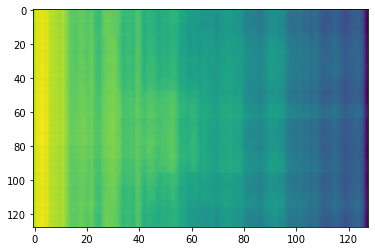

2020-11-07 09:40:25,019 - pytorch_modeler.py - INFO - Epoch 10/100:train_loss:172.438924, valid_AUC:0.473239, valid_pAUC:0.498098
100%|██████████| 3452/3452 [00:35<00:00, 98.00it/s]
2020-11-07 09:41:50,070 - pytorch_modeler.py - INFO - Epoch 11/100:train_loss:150.866573, valid_AUC:0.480247, valid_pAUC:0.501280
100%|██████████| 3452/3452 [00:35<00:00, 98.34it/s]
2020-11-07 09:43:15,068 - pytorch_modeler.py - INFO - Epoch 12/100:train_loss:131.643947, valid_AUC:0.477609, valid_pAUC:0.499188
100%|██████████| 3452/3452 [00:35<00:00, 98.35it/s]
2020-11-07 09:44:40,006 - pytorch_modeler.py - INFO - Epoch 13/100:train_loss:114.799095, valid_AUC:0.483731, valid_pAUC:0.500090
100%|██████████| 3452/3452 [00:35<00:00, 97.72it/s]
2020-11-07 09:46:05,226 - pytorch_modeler.py - INFO - Epoch 14/100:train_loss:99.986759, valid_AUC:0.475678, valid_pAUC:0.502808
100%|██████████| 3452/3452 [00:35<00:00, 98.17it/s]
2020-11-07 09:47:30,242 - pytorch_modeler.py - INFO - Epoch 15/100:train_loss:87.072609, va

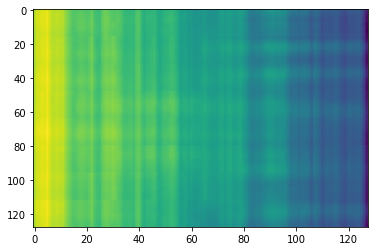

2020-11-07 09:54:35,386 - pytorch_modeler.py - INFO - Epoch 20/100:train_loss:43.782224, valid_AUC:0.535647, valid_pAUC:0.513351
100%|██████████| 3452/3452 [00:35<00:00, 97.93it/s]
2020-11-07 09:56:00,439 - pytorch_modeler.py - INFO - Epoch 21/100:train_loss:38.167667, valid_AUC:0.578817, valid_pAUC:0.523932
100%|██████████| 3452/3452 [00:35<00:00, 98.32it/s]
2020-11-07 09:57:25,374 - pytorch_modeler.py - INFO - Epoch 22/100:train_loss:33.446853, valid_AUC:0.585645, valid_pAUC:0.521889
100%|██████████| 3452/3452 [00:35<00:00, 98.25it/s]
2020-11-07 09:58:50,490 - pytorch_modeler.py - INFO - Epoch 23/100:train_loss:29.737603, valid_AUC:0.604288, valid_pAUC:0.526237
100%|██████████| 3452/3452 [00:35<00:00, 98.18it/s]
2020-11-07 10:00:15,458 - pytorch_modeler.py - INFO - Epoch 24/100:train_loss:26.262623, valid_AUC:0.610293, valid_pAUC:0.525513
100%|██████████| 3452/3452 [00:35<00:00, 97.88it/s]
2020-11-07 10:01:40,546 - pytorch_modeler.py - INFO - Epoch 25/100:train_loss:23.502373, valid_

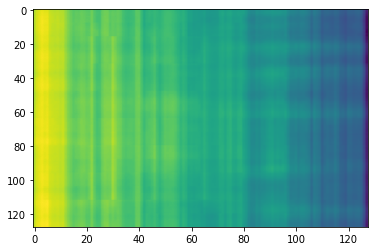

2020-11-07 10:08:45,294 - pytorch_modeler.py - INFO - Epoch 30/100:train_loss:15.343507, valid_AUC:0.646090, valid_pAUC:0.544714
100%|██████████| 3452/3452 [00:35<00:00, 97.85it/s]
2020-11-07 10:10:10,327 - pytorch_modeler.py - INFO - Epoch 31/100:train_loss:14.506155, valid_AUC:0.656164, valid_pAUC:0.525011
100%|██████████| 3452/3452 [00:35<00:00, 98.24it/s]
2020-11-07 10:11:35,269 - pytorch_modeler.py - INFO - Epoch 32/100:train_loss:13.878036, valid_AUC:0.639030, valid_pAUC:0.522346
100%|██████████| 3452/3452 [00:35<00:00, 98.48it/s]
2020-11-07 10:13:00,092 - pytorch_modeler.py - INFO - Epoch 33/100:train_loss:13.411910, valid_AUC:0.624968, valid_pAUC:0.526893
100%|██████████| 3452/3452 [00:35<00:00, 98.31it/s]
2020-11-07 10:14:25,014 - pytorch_modeler.py - INFO - Epoch 34/100:train_loss:12.953506, valid_AUC:0.659962, valid_pAUC:0.527304
100%|██████████| 3452/3452 [00:35<00:00, 97.68it/s]
2020-11-07 10:15:50,144 - pytorch_modeler.py - INFO - Epoch 35/100:train_loss:12.638622, valid_

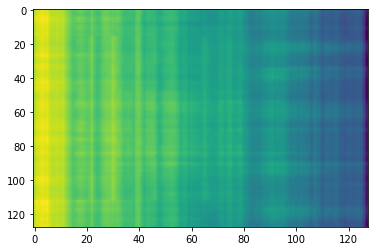

2020-11-07 10:22:54,939 - pytorch_modeler.py - INFO - Epoch 40/100:train_loss:11.876315, valid_AUC:0.642660, valid_pAUC:0.534296
100%|██████████| 3452/3452 [00:35<00:00, 98.31it/s]
2020-11-07 10:24:19,813 - pytorch_modeler.py - INFO - Epoch 41/100:train_loss:11.619083, valid_AUC:0.661332, valid_pAUC:0.550043
100%|██████████| 3452/3452 [00:35<00:00, 98.02it/s]
2020-11-07 10:25:44,858 - pytorch_modeler.py - INFO - Epoch 42/100:train_loss:11.475625, valid_AUC:0.667239, valid_pAUC:0.549549
100%|██████████| 3452/3452 [00:35<00:00, 98.44it/s]
2020-11-07 10:27:09,705 - pytorch_modeler.py - INFO - Epoch 43/100:train_loss:11.424521, valid_AUC:0.677588, valid_pAUC:0.550483
100%|██████████| 3452/3452 [00:35<00:00, 98.46it/s]
2020-11-07 10:28:34,517 - pytorch_modeler.py - INFO - Epoch 44/100:train_loss:11.356529, valid_AUC:0.648416, valid_pAUC:0.534666
100%|██████████| 3452/3452 [00:35<00:00, 97.78it/s]
2020-11-07 10:29:59,648 - pytorch_modeler.py - INFO - Epoch 45/100:train_loss:11.279757, valid_

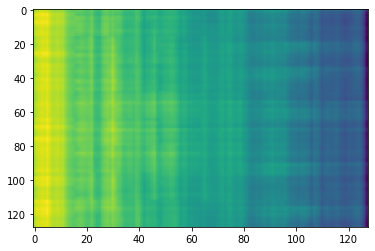

2020-11-07 10:37:04,209 - pytorch_modeler.py - INFO - Epoch 50/100:train_loss:11.025643, valid_AUC:0.678604, valid_pAUC:0.554939
100%|██████████| 3452/3452 [00:35<00:00, 98.55it/s]
2020-11-07 10:38:29,045 - pytorch_modeler.py - INFO - Epoch 51/100:train_loss:11.008728, valid_AUC:0.654402, valid_pAUC:0.536332
100%|██████████| 3452/3452 [00:35<00:00, 98.01it/s]
2020-11-07 10:39:54,035 - pytorch_modeler.py - INFO - Epoch 52/100:train_loss:10.938783, valid_AUC:0.676431, valid_pAUC:0.555827
100%|██████████| 3452/3452 [00:35<00:00, 98.59it/s]
2020-11-07 10:41:18,827 - pytorch_modeler.py - INFO - Epoch 53/100:train_loss:10.864502, valid_AUC:0.684262, valid_pAUC:0.563825
100%|██████████| 3452/3452 [00:35<00:00, 98.50it/s]
2020-11-07 10:42:43,663 - pytorch_modeler.py - INFO - Epoch 54/100:train_loss:10.818895, valid_AUC:0.695699, valid_pAUC:0.569726
100%|██████████| 3452/3452 [00:35<00:00, 97.98it/s]
2020-11-07 10:44:08,768 - pytorch_modeler.py - INFO - Epoch 55/100:train_loss:10.711805, valid_

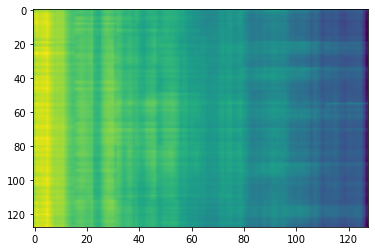

2020-11-07 10:51:13,317 - pytorch_modeler.py - INFO - Epoch 60/100:train_loss:10.548872, valid_AUC:0.656977, valid_pAUC:0.564274
100%|██████████| 3452/3452 [00:35<00:00, 98.54it/s]
2020-11-07 10:52:38,115 - pytorch_modeler.py - INFO - Epoch 61/100:train_loss:10.482949, valid_AUC:0.627248, valid_pAUC:0.525501
100%|██████████| 3452/3452 [00:35<00:00, 98.20it/s]
2020-11-07 10:54:03,062 - pytorch_modeler.py - INFO - Epoch 62/100:train_loss:10.370096, valid_AUC:0.672010, valid_pAUC:0.564746
100%|██████████| 3452/3452 [00:34<00:00, 98.64it/s]
2020-11-07 10:55:27,815 - pytorch_modeler.py - INFO - Epoch 63/100:train_loss:10.373685, valid_AUC:0.691806, valid_pAUC:0.579244
100%|██████████| 3452/3452 [00:35<00:00, 98.52it/s]
2020-11-07 10:56:52,676 - pytorch_modeler.py - INFO - Epoch 64/100:train_loss:10.834418, valid_AUC:0.600067, valid_pAUC:0.517875
100%|██████████| 3452/3452 [00:35<00:00, 98.31it/s]
2020-11-07 10:58:17,507 - pytorch_modeler.py - INFO - Epoch 65/100:train_loss:11.175047, valid_

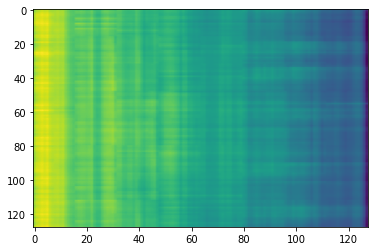

2020-11-07 11:05:22,120 - pytorch_modeler.py - INFO - Epoch 70/100:train_loss:10.253611, valid_AUC:0.693740, valid_pAUC:0.579970
100%|██████████| 3452/3452 [00:34<00:00, 98.65it/s]
2020-11-07 11:06:46,916 - pytorch_modeler.py - INFO - Epoch 71/100:train_loss:10.292299, valid_AUC:0.688012, valid_pAUC:0.572031
100%|██████████| 3452/3452 [00:35<00:00, 98.16it/s]
2020-11-07 11:08:11,889 - pytorch_modeler.py - INFO - Epoch 72/100:train_loss:10.266984, valid_AUC:0.710310, valid_pAUC:0.588521
100%|██████████| 3452/3452 [00:35<00:00, 98.38it/s]
2020-11-07 11:09:36,724 - pytorch_modeler.py - INFO - Epoch 73/100:train_loss:10.182129, valid_AUC:0.676554, valid_pAUC:0.554643
100%|██████████| 3452/3452 [00:34<00:00, 98.69it/s]
2020-11-07 11:11:01,433 - pytorch_modeler.py - INFO - Epoch 74/100:train_loss:10.143693, valid_AUC:0.696901, valid_pAUC:0.578747
100%|██████████| 3452/3452 [00:35<00:00, 98.41it/s]
2020-11-07 11:12:26,290 - pytorch_modeler.py - INFO - Epoch 75/100:train_loss:10.144931, valid_

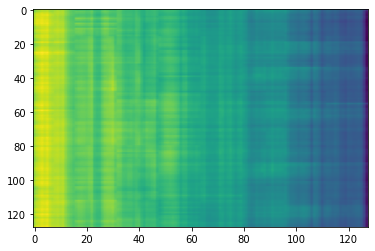

2020-11-07 11:19:30,930 - pytorch_modeler.py - INFO - Epoch 80/100:train_loss:10.031613, valid_AUC:0.692058, valid_pAUC:0.571254
100%|██████████| 3452/3452 [00:34<00:00, 98.63it/s]
2020-11-07 11:20:55,710 - pytorch_modeler.py - INFO - Epoch 81/100:train_loss:10.022461, valid_AUC:0.675999, valid_pAUC:0.576513
100%|██████████| 3452/3452 [00:35<00:00, 98.42it/s]
2020-11-07 11:22:20,675 - pytorch_modeler.py - INFO - Epoch 82/100:train_loss:9.969847, valid_AUC:0.699071, valid_pAUC:0.553995
100%|██████████| 3452/3452 [00:35<00:00, 98.26it/s]
2020-11-07 11:23:45,593 - pytorch_modeler.py - INFO - Epoch 83/100:train_loss:9.958837, valid_AUC:0.705844, valid_pAUC:0.580889
100%|██████████| 3452/3452 [00:34<00:00, 98.70it/s]
2020-11-07 11:25:10,282 - pytorch_modeler.py - INFO - Epoch 84/100:train_loss:9.897097, valid_AUC:0.695005, valid_pAUC:0.581208
100%|██████████| 3452/3452 [00:34<00:00, 98.76it/s]
2020-11-07 11:26:34,966 - pytorch_modeler.py - INFO - Epoch 85/100:train_loss:9.925888, valid_AUC:

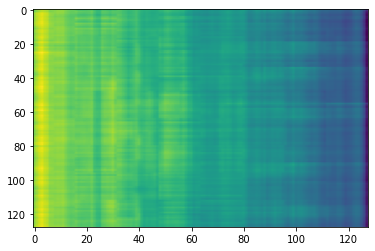

2020-11-07 11:33:39,176 - pytorch_modeler.py - INFO - Epoch 90/100:train_loss:9.793310, valid_AUC:0.719202, valid_pAUC:0.568740
100%|██████████| 3452/3452 [00:34<00:00, 98.77it/s]
2020-11-07 11:35:03,856 - pytorch_modeler.py - INFO - Epoch 91/100:train_loss:9.806878, valid_AUC:0.700491, valid_pAUC:0.586895
100%|██████████| 3452/3452 [00:35<00:00, 98.61it/s]
2020-11-07 11:36:28,604 - pytorch_modeler.py - INFO - Epoch 92/100:train_loss:9.752003, valid_AUC:0.702990, valid_pAUC:0.579956
100%|██████████| 3452/3452 [00:35<00:00, 98.32it/s]
2020-11-07 11:37:53,506 - pytorch_modeler.py - INFO - Epoch 93/100:train_loss:9.629165, valid_AUC:0.694393, valid_pAUC:0.584682
100%|██████████| 3452/3452 [00:35<00:00, 98.52it/s]
2020-11-07 11:39:18,206 - pytorch_modeler.py - INFO - Epoch 94/100:train_loss:9.637566, valid_AUC:0.687356, valid_pAUC:0.576607
100%|██████████| 3452/3452 [00:34<00:00, 98.65it/s]
2020-11-07 11:40:42,932 - pytorch_modeler.py - INFO - Epoch 95/100:train_loss:9.573355, valid_AUC:0.

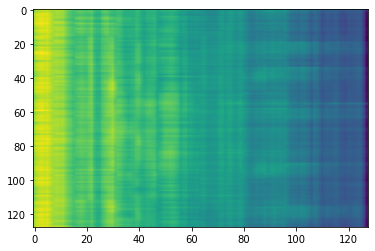

2020-11-07 11:47:47,291 - pytorch_modeler.py - INFO - Epoch 100/100:train_loss:9.483828, valid_AUC:0.702720, valid_pAUC:0.592629
2020-11-07 11:47:47,435 - 00_train.py - INFO - 
 success:ToyConveyor 
model_out_path ==> 
 /media/hiroki/working/research/dcase2020/result/2D/LSTM3CNN_AE/models/ToyConveyor_model.pth


elapsed time: 8573.260186672 [sec]


2020-11-07 11:47:48,095 - 00_train.py - INFO - TARGET MACHINE_TYPE: valve
2020-11-07 11:47:48,095 - 00_train.py - INFO - MAKE DATA_LOADER
2020-11-07 11:47:48,097 - 00_train.py - INFO - TRAINING
  0%|          | 0/91 [00:00<?, ?it/s]

use: cuda:0


100%|██████████| 855/855 [00:14<00:00, 60.88it/s]


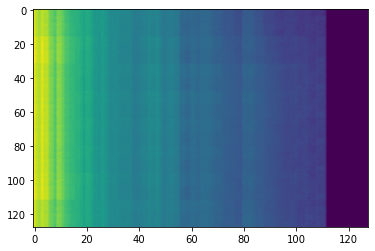

2020-11-07 11:49:46,709 - pytorch_modeler.py - INFO - Epoch 1/100:train_loss:1000.241542, valid_AUC:0.492830, valid_pAUC:0.502805
100%|██████████| 855/855 [00:08<00:00, 98.72it/s]
2020-11-07 11:50:43,651 - pytorch_modeler.py - INFO - Epoch 2/100:train_loss:935.106216, valid_AUC:0.493874, valid_pAUC:0.502892
100%|██████████| 855/855 [00:08<00:00, 96.79it/s]
2020-11-07 11:51:40,872 - pytorch_modeler.py - INFO - Epoch 3/100:train_loss:875.414755, valid_AUC:0.496242, valid_pAUC:0.503036
100%|██████████| 855/855 [00:08<00:00, 98.53it/s]
2020-11-07 11:52:37,939 - pytorch_modeler.py - INFO - Epoch 4/100:train_loss:819.290287, valid_AUC:0.482846, valid_pAUC:0.503297
100%|██████████| 855/855 [00:08<00:00, 98.59it/s]
2020-11-07 11:53:35,083 - pytorch_modeler.py - INFO - Epoch 5/100:train_loss:765.682360, valid_AUC:0.482824, valid_pAUC:0.503008
100%|██████████| 855/855 [00:08<00:00, 98.29it/s]
2020-11-07 11:54:32,266 - pytorch_modeler.py - INFO - Epoch 6/100:train_loss:716.445972, valid_AUC:0.490

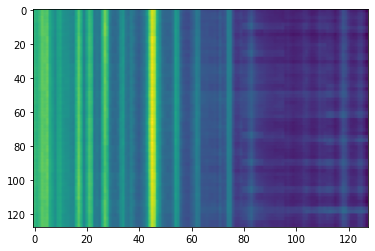

2020-11-07 11:58:20,932 - pytorch_modeler.py - INFO - Epoch 10/100:train_loss:548.043083, valid_AUC:0.489725, valid_pAUC:0.499451
100%|██████████| 855/855 [00:08<00:00, 98.42it/s]
2020-11-07 11:59:18,025 - pytorch_modeler.py - INFO - Epoch 11/100:train_loss:509.903647, valid_AUC:0.472121, valid_pAUC:0.493667
100%|██████████| 855/855 [00:08<00:00, 98.70it/s]
2020-11-07 12:00:15,182 - pytorch_modeler.py - INFO - Epoch 12/100:train_loss:473.979610, valid_AUC:0.492107, valid_pAUC:0.496703
100%|██████████| 855/855 [00:08<00:00, 98.63it/s]
2020-11-07 12:01:12,255 - pytorch_modeler.py - INFO - Epoch 13/100:train_loss:440.883595, valid_AUC:0.472714, valid_pAUC:0.496790
100%|██████████| 855/855 [00:08<00:00, 98.74it/s]
2020-11-07 12:02:09,300 - pytorch_modeler.py - INFO - Epoch 14/100:train_loss:409.632966, valid_AUC:0.481846, valid_pAUC:0.496270
100%|██████████| 855/855 [00:08<00:00, 98.73it/s]
2020-11-07 12:03:06,310 - pytorch_modeler.py - INFO - Epoch 15/100:train_loss:380.263410, valid_AUC:

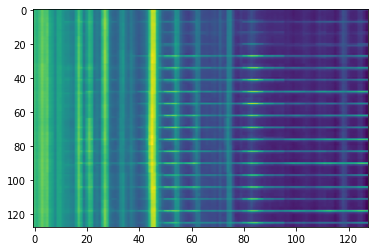

2020-11-07 12:07:51,944 - pytorch_modeler.py - INFO - Epoch 20/100:train_loss:256.654171, valid_AUC:0.481082, valid_pAUC:0.501938
100%|██████████| 855/855 [00:08<00:00, 98.71it/s]
2020-11-07 12:08:48,990 - pytorch_modeler.py - INFO - Epoch 21/100:train_loss:236.056912, valid_AUC:0.473750, valid_pAUC:0.502313
100%|██████████| 855/855 [00:08<00:00, 96.79it/s]
2020-11-07 12:09:46,217 - pytorch_modeler.py - INFO - Epoch 22/100:train_loss:216.632491, valid_AUC:0.469956, valid_pAUC:0.500000
100%|██████████| 855/855 [00:08<00:00, 98.48it/s]
2020-11-07 12:10:43,286 - pytorch_modeler.py - INFO - Epoch 23/100:train_loss:198.549359, valid_AUC:0.465030, valid_pAUC:0.493840
100%|██████████| 855/855 [00:08<00:00, 96.50it/s]
2020-11-07 12:11:40,531 - pytorch_modeler.py - INFO - Epoch 24/100:train_loss:181.530065, valid_AUC:0.483668, valid_pAUC:0.487941
100%|██████████| 855/855 [00:08<00:00, 98.68it/s]
2020-11-07 12:12:37,591 - pytorch_modeler.py - INFO - Epoch 25/100:train_loss:165.664251, valid_AUC:

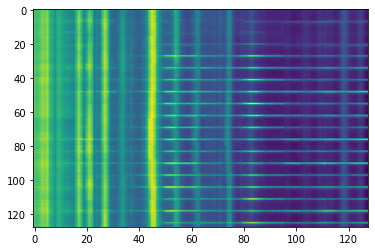

2020-11-07 12:17:23,066 - pytorch_modeler.py - INFO - Epoch 30/100:train_loss:101.560220, valid_AUC:0.506709, valid_pAUC:0.496096
100%|██████████| 855/855 [00:08<00:00, 99.00it/s]
2020-11-07 12:18:20,100 - pytorch_modeler.py - INFO - Epoch 31/100:train_loss:91.495299, valid_AUC:0.519852, valid_pAUC:0.496935
100%|██████████| 855/855 [00:08<00:00, 98.46it/s]
2020-11-07 12:19:17,194 - pytorch_modeler.py - INFO - Epoch 32/100:train_loss:82.245899, valid_AUC:0.475005, valid_pAUC:0.493783
100%|██████████| 855/855 [00:08<00:00, 98.60it/s]
2020-11-07 12:20:14,265 - pytorch_modeler.py - INFO - Epoch 33/100:train_loss:73.751656, valid_AUC:0.533481, valid_pAUC:0.495894
100%|██████████| 855/855 [00:08<00:00, 98.49it/s]
2020-11-07 12:21:11,326 - pytorch_modeler.py - INFO - Epoch 34/100:train_loss:66.130409, valid_AUC:0.518786, valid_pAUC:0.499104
100%|██████████| 855/855 [00:08<00:00, 98.45it/s]
2020-11-07 12:22:08,427 - pytorch_modeler.py - INFO - Epoch 35/100:train_loss:59.009478, valid_AUC:0.543

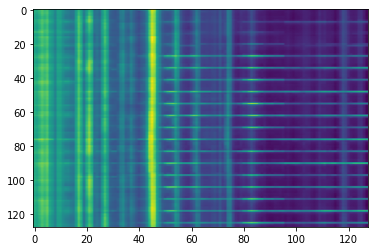

2020-11-07 12:26:53,953 - pytorch_modeler.py - INFO - Epoch 40/100:train_loss:33.141845, valid_AUC:0.547728, valid_pAUC:0.492481
100%|██████████| 855/855 [00:08<00:00, 98.38it/s]
2020-11-07 12:27:51,195 - pytorch_modeler.py - INFO - Epoch 41/100:train_loss:29.498675, valid_AUC:0.516879, valid_pAUC:0.498438
100%|██████████| 855/855 [00:08<00:00, 98.74it/s]
2020-11-07 12:28:48,239 - pytorch_modeler.py - INFO - Epoch 42/100:train_loss:26.323483, valid_AUC:0.525165, valid_pAUC:0.499479
100%|██████████| 855/855 [00:08<00:00, 96.73it/s]
2020-11-07 12:29:45,460 - pytorch_modeler.py - INFO - Epoch 43/100:train_loss:23.521254, valid_AUC:0.537599, valid_pAUC:0.497021
100%|██████████| 855/855 [00:08<00:00, 98.89it/s]
2020-11-07 12:30:42,543 - pytorch_modeler.py - INFO - Epoch 44/100:train_loss:21.087436, valid_AUC:0.552852, valid_pAUC:0.506767
100%|██████████| 855/855 [00:08<00:00, 96.48it/s]
2020-11-07 12:31:39,821 - pytorch_modeler.py - INFO - Epoch 45/100:train_loss:18.991935, valid_AUC:0.5533

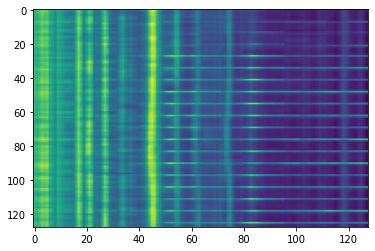

2020-11-07 12:36:25,458 - pytorch_modeler.py - INFO - Epoch 50/100:train_loss:12.274338, valid_AUC:0.601505, valid_pAUC:0.499826
100%|██████████| 855/855 [00:08<00:00, 98.72it/s]
2020-11-07 12:37:22,528 - pytorch_modeler.py - INFO - Epoch 51/100:train_loss:11.465354, valid_AUC:0.601687, valid_pAUC:0.500578
100%|██████████| 855/855 [00:08<00:00, 98.60it/s]
2020-11-07 12:38:19,633 - pytorch_modeler.py - INFO - Epoch 52/100:train_loss:10.827136, valid_AUC:0.552192, valid_pAUC:0.507837
100%|██████████| 855/855 [00:08<00:00, 98.60it/s]
2020-11-07 12:39:16,689 - pytorch_modeler.py - INFO - Epoch 53/100:train_loss:10.291698, valid_AUC:0.579907, valid_pAUC:0.499971
100%|██████████| 855/855 [00:08<00:00, 98.32it/s]
2020-11-07 12:40:13,752 - pytorch_modeler.py - INFO - Epoch 54/100:train_loss:9.859215, valid_AUC:0.579547, valid_pAUC:0.503210
100%|██████████| 855/855 [00:08<00:00, 98.64it/s]
2020-11-07 12:41:10,773 - pytorch_modeler.py - INFO - Epoch 55/100:train_loss:9.563506, valid_AUC:0.588038

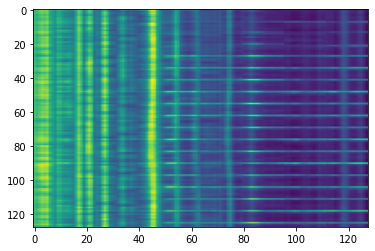

2020-11-07 12:45:56,239 - pytorch_modeler.py - INFO - Epoch 60/100:train_loss:8.576397, valid_AUC:0.588055, valid_pAUC:0.504049
100%|██████████| 855/855 [00:08<00:00, 98.76it/s]
2020-11-07 12:46:53,255 - pytorch_modeler.py - INFO - Epoch 61/100:train_loss:8.458474, valid_AUC:0.582868, valid_pAUC:0.504078
100%|██████████| 855/855 [00:08<00:00, 98.64it/s]
2020-11-07 12:47:50,319 - pytorch_modeler.py - INFO - Epoch 62/100:train_loss:8.301966, valid_AUC:0.578819, valid_pAUC:0.507634
100%|██████████| 855/855 [00:08<00:00, 98.88it/s]
2020-11-07 12:48:47,389 - pytorch_modeler.py - INFO - Epoch 63/100:train_loss:8.152303, valid_AUC:0.598121, valid_pAUC:0.504511
100%|██████████| 855/855 [00:08<00:00, 96.21it/s]
2020-11-07 12:49:44,645 - pytorch_modeler.py - INFO - Epoch 64/100:train_loss:8.138896, valid_AUC:0.585648, valid_pAUC:0.506391
100%|██████████| 855/855 [00:08<00:00, 98.76it/s]
2020-11-07 12:50:41,676 - pytorch_modeler.py - INFO - Epoch 65/100:train_loss:7.980971, valid_AUC:0.581874, va

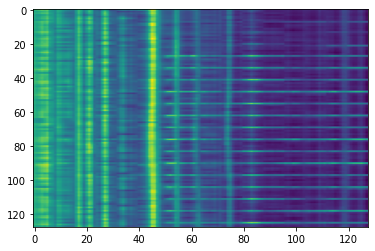

2020-11-07 12:55:27,254 - pytorch_modeler.py - INFO - Epoch 70/100:train_loss:7.740532, valid_AUC:0.609505, valid_pAUC:0.507519
100%|██████████| 855/855 [00:08<00:00, 98.35it/s]
2020-11-07 12:56:24,306 - pytorch_modeler.py - INFO - Epoch 71/100:train_loss:7.756074, valid_AUC:0.595648, valid_pAUC:0.507895
100%|██████████| 855/855 [00:09<00:00, 89.97it/s]
2020-11-07 12:57:23,914 - pytorch_modeler.py - INFO - Epoch 72/100:train_loss:7.716931, valid_AUC:0.608291, valid_pAUC:0.505147
100%|██████████| 855/855 [00:08<00:00, 95.84it/s]
2020-11-07 12:58:23,002 - pytorch_modeler.py - INFO - Epoch 73/100:train_loss:7.748953, valid_AUC:0.591269, valid_pAUC:0.505870
100%|██████████| 855/855 [00:09<00:00, 89.73it/s]
2020-11-07 12:59:22,672 - pytorch_modeler.py - INFO - Epoch 74/100:train_loss:7.642717, valid_AUC:0.600777, valid_pAUC:0.505495
100%|██████████| 855/855 [00:09<00:00, 91.39it/s]
2020-11-07 13:00:22,413 - pytorch_modeler.py - INFO - Epoch 75/100:train_loss:7.652533, valid_AUC:0.595269, va

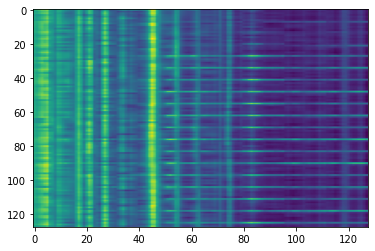

2020-11-07 13:05:10,650 - pytorch_modeler.py - INFO - Epoch 80/100:train_loss:7.542539, valid_AUC:0.606121, valid_pAUC:0.510237
100%|██████████| 855/855 [00:08<00:00, 98.65it/s]
2020-11-07 13:06:08,022 - pytorch_modeler.py - INFO - Epoch 81/100:train_loss:7.501726, valid_AUC:0.613533, valid_pAUC:0.510295
100%|██████████| 855/855 [00:08<00:00, 98.86it/s]
2020-11-07 13:07:05,045 - pytorch_modeler.py - INFO - Epoch 82/100:train_loss:7.543675, valid_AUC:0.601093, valid_pAUC:0.507490
100%|██████████| 855/855 [00:08<00:00, 99.00it/s]
2020-11-07 13:08:02,034 - pytorch_modeler.py - INFO - Epoch 83/100:train_loss:7.528601, valid_AUC:0.604736, valid_pAUC:0.508502
100%|██████████| 855/855 [00:08<00:00, 98.81it/s]
2020-11-07 13:08:58,998 - pytorch_modeler.py - INFO - Epoch 84/100:train_loss:7.487666, valid_AUC:0.600209, valid_pAUC:0.511249
100%|██████████| 855/855 [00:08<00:00, 98.56it/s]
2020-11-07 13:09:56,042 - pytorch_modeler.py - INFO - Epoch 85/100:train_loss:7.434656, valid_AUC:0.600374, va

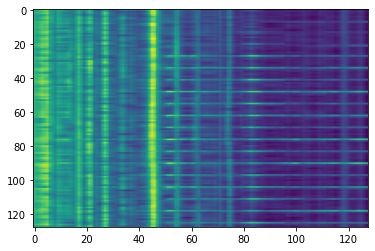

2020-11-07 13:14:41,507 - pytorch_modeler.py - INFO - Epoch 90/100:train_loss:7.407577, valid_AUC:0.611604, valid_pAUC:0.508068
100%|██████████| 855/855 [00:08<00:00, 98.07it/s]
2020-11-07 13:15:38,578 - pytorch_modeler.py - INFO - Epoch 91/100:train_loss:7.375325, valid_AUC:0.628126, valid_pAUC:0.510006
100%|██████████| 855/855 [00:08<00:00, 98.64it/s]
2020-11-07 13:16:35,657 - pytorch_modeler.py - INFO - Epoch 92/100:train_loss:7.343682, valid_AUC:0.608967, valid_pAUC:0.508647
100%|██████████| 855/855 [00:08<00:00, 98.79it/s]
2020-11-07 13:17:32,683 - pytorch_modeler.py - INFO - Epoch 93/100:train_loss:7.360816, valid_AUC:0.613264, valid_pAUC:0.508647
100%|██████████| 855/855 [00:08<00:00, 98.99it/s]
2020-11-07 13:18:29,699 - pytorch_modeler.py - INFO - Epoch 94/100:train_loss:7.324749, valid_AUC:0.610742, valid_pAUC:0.509803
100%|██████████| 855/855 [00:08<00:00, 98.25it/s]
2020-11-07 13:19:26,781 - pytorch_modeler.py - INFO - Epoch 95/100:train_loss:7.312904, valid_AUC:0.607901, va

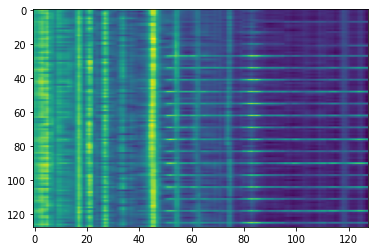

2020-11-07 13:24:12,116 - pytorch_modeler.py - INFO - Epoch 100/100:train_loss:7.144478, valid_AUC:0.617209, valid_pAUC:0.506564
2020-11-07 13:24:12,263 - 00_train.py - INFO - 
 success:valve 
model_out_path ==> 
 /media/hiroki/working/research/dcase2020/result/2D/LSTM3CNN_AE/models/valve_model.pth


elapsed time: 5784.169742823 [sec]


In [11]:
for machine_type in machine_types:
    history = run(machine_type)
    with open('{}/{}_history.pkl'.format(PKL_DIR, machine_type), 'wb') as file:
        pickle.dump(history , file)

history = run('ToyCar')
with open('{}/{}_history.pkl'.format(PKL_DIR, machine_type), 'wb') as file:
    pickle.dump(history , file)